# Credit Card Attrition
Determining the signs of impending credit card attrition among current customers. 

# Document Setup

## Importing Libraries

In [1]:
# # CHECK
# ## for installed packages
# ! pip list


# # INSTALL
# ## packages
# ! pip install ____


# IMPORT
## Libraries
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from scipy import stats
from sqlalchemy import create_engine
from statsmodels.stats import weightstats as stests
import math
import plotly.graph_objects as go
import more_itertools as mit
from statsmodels.stats import weightstats as stests


# SUPPRESS
## warnings
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Formatting

In [2]:
# DISPLAY
## up to 30 columns
# pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 150)



# SEABORN
## set plot background color
sns.set_style("white")

## Importing Dataset

### Kaggle location:
https://www.kaggle.com/sakshigoyal7/credit-card-customers

---

### GitHub repository: 
https://github.com/RobertAlber/Credit_Card_Customer_Attrition

---

### BankChurners csv: 
https://raw.githubusercontent.com/RobertAlber/Credit_Card_Customer_Attrition/main/BankChurners.csv

In [3]:
# IMPORT
## dataset from GitHub
df_raw = pd.read_csv('https://raw.githubusercontent.com/RobertAlber/Credit_Card_Customer_Attrition/main/BankChurners.csv')


# INFO
df_raw.info()


## PREVIEW
print('')
display(df_raw)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.999910
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.999940
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.999980
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.999870
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.999980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,3,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462,0.000191,0.999810
10123,710638233,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,4,2,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511,0.995270,0.004729
10124,716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,5,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000,0.997880,0.002118
10125,717406983,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,4,3,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000,0.996710,0.003294


## Clean Dataset for Analysis

In [4]:
# DROP
## the last 2 columns
cc_drop = df_raw.drop(df_raw.columns[[21,22]], axis=1)


# RENAME
## columns
cc_col_name = cc_drop.rename(columns={'CLIENTNUM': 'customer_id'})


# LOWER CASE
## column names all to lowercase
cc_col_name.columns = cc_col_name.columns.str.lower()


# DEFINE
## new parent DataFrame
df = cc_col_name


# DEFINE function for updating Gender column
def func2(row):
  if row['gender'] == 'M':
    val = 'Male'
  elif row['gender'] == 'F':
    val = 'Female'
  return val
# ADD column
df['gender'] = df.apply(func2, axis=1)
# MOVE column
cols = df.columns.tolist() # list of columns
cols.insert(2, cols.pop(cols.index('gender')))
df = df.reindex(columns = cols)


# DEFINE
## function for adding attrition_status column
def func(row):
  if row['attrition_flag'] == 'Attrited Customer':
    val = 1
  elif row['attrition_flag'] == 'Existing Customer':
    val = 0
  return val
# ADD column
df['attrition_status'] = df.apply(func, axis=1)
# MOVE column
cols = df.columns.tolist() # list of columns
cols.insert(2, cols.pop(cols.index('attrition_status')))
df = df.reindex(columns = cols)


## TESTING PREP
df_attrited = df.loc[df['attrition_flag'] == 'Attrited Customer']
df_existing = df.loc[df['attrition_flag'] == 'Existing Customer']


# CREATE DataFrame for attrition_percentage
df_attrition = pd.DataFrame(columns = ['category', 'min_attrition_percent', 'max_attrition_percent', 'attrition_percent_range'])
print(df_attrition)


# CREATE DataFrame for attrition_percentage
df_attrition_all = pd.DataFrame(columns = ['category', 'min_attrition_percent', 'max_attrition_percent', 'attrition_percent_range'])
print(df_attrition_all)


# INFO
df.info()

Empty DataFrame
Columns: [category, min_attrition_percent, max_attrition_percent, attrition_percent_range]
Index: []
Empty DataFrame
Columns: [category, min_attrition_percent, max_attrition_percent, attrition_percent_range]
Index: []
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10127 non-null  int64  
 1   attrition_flag            10127 non-null  object 
 2   attrition_status          10127 non-null  int64  
 3   gender                    10127 non-null  object 
 4   customer_age              10127 non-null  int64  
 5   dependent_count           10127 non-null  int64  
 6   education_level           10127 non-null  object 
 7   marital_status            10127 non-null  object 
 8   income_category           10127 non-null  object 
 9   card_category             10127 non-null  objec

## Define Functions

### General Functions

In [5]:
# DEFINE FUNCTION: colname()
## define column name for functional programming
def colname():
  x = column_name
  return x





#############################
########## PREVIEW ##########
#############################

# DEFINE FUNCTION: 
## maximum number of bins to separate data into
def max_bins():
  max = df[colname()].max()
  if df.dtypes[colname()] != 'int64':
    return 8
  elif max > 8:
    return 8
  else:
    return max


  
# DEFINE FUNCTION: 
## create cross tab for preview data with defined number of bins
def preview():
  '''type something'''
  if (df.dtypes[colname()] == 'int64' 
      or df.dtypes[colname()] == 'float64'):
    # GROUPING
    ctab_groups = pd.cut(df[colname()], 
                         bins=num_bins)
    # CREATE 
    ## crosstab
    ctab = pd.crosstab(ctab_groups, df['attrition_flag'])
    # LOWER CASE
    ## column names all to lowercase
    ctab.columns = ctab.columns.str.lower()
    # REPLACE
    ## ' ' with '_'
    ctab.columns = ctab.columns.str.replace(' ','_')
    ## CALCULATE total customers by category
    ctab['total_customers'] = (ctab['attrited_customer'] + 
                               ctab['existing_customer'])
    ## MOVE column total customers by category
    cols = ctab.columns.tolist() # list of columns
    cols.insert(0, cols.pop(cols.index('total_customers')))
    ctab = ctab.reindex(columns = cols)
    ## CALCULATE attrition rate
    ctab['attrition_percent'] = round(((ctab['attrited_customer'] / 
                                        ctab['total_customers']) * 100), 2)
    return ctab
  elif 0 == 1:
    'test'
  else:
    return 'need to define function'



# DEFINE FUNCTION:
## print preview pivot table
def pivot_preview(): 
  print('\nPREVIEW DATA')
  print('\n\'{}\' is separated into {} preliminary groups as a preview of the data.\n'.format(colname().replace('_', ' ').title(), 
                                                                                              num_bins))
  return preview()



# DEFINE FUNCTION:
## bar plot of the preview data
def bplot_preview():
  ## SETTINGS plot size
  plotsize = plt.figure(figsize=(plot_width_prev, plot_height_prev))
  ay, fig = plt.subplots(figsize=(plot_width_prev, plot_height_prev))
  ## CREATE plot
  pv = preview()
  bplot = sns.barplot(x=pv.index, y="attrition_percent", data=pv)
  ## FORMAT plot labels
  for p in bplot.patches:
    bplot.annotate('{:.2f}%'.format(p.get_height()), 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  va = 'center', 
                  xytext = (0, 10), 
                  textcoords = 'offset points',
                  ha = 'center')
  ## FORMAT plot labels
  plt.xlabel(colname().replace('_',' ').title())
  plt.ylabel('Attrition Percentage')
  plt.title('Attrition Rate by ' + colname().replace('_',' ').title(), 
            pad=25)
  sns.despine()
  y = 'Attrition Percentage'
  ylabels = ['{:.0f}'.format(y) + '%' for y in bplot.get_yticks()]
  bplot.set_yticklabels(ylabels)
  bplot.set_xticklabels(bplot.get_xticklabels(), rotation = x_axis_ang_prev, horizontalalignment = horiz_align_prev)
  ## PRINT
  print('')
  return plt.show()





##############################
########## TESTING ###########
##############################

## max value in column
def max_value():
  x = df[colname()].max()
  return x

## mean value in column
def mean_value():
  x = df[colname()].mean()
  return x

## value for calculating less than
def num_val_1():
  x = less_than_num
  return x

## value for calculating greater than or equal to
def num_val_2():
  x = less_than_num
  return x

## no exclusions from test groups
def no_exclusions():
   while True:
     try:
       x = max_value() + 1
       return x
     except (RuntimeError, TypeError, NameError):
       x = len(group_names) + 1
       return x

## value for calculating exclusion
def num_exclude_plus():
  z = exclude_plus - 1
  return z


## DEFINE FUNCTION: 
def test_groups():
  if value1.dtypes == 'str':
    group_a = df.loc[df[colname()] == str_val_1]
    group_b = df.loc[df[colname()] == str_val_2]
  else:
    group_a = df.loc[df[colname()] < num_val_1()]
    group_b = df.loc[df[colname()] >= num_val_2()]


## DEFINE FUNCTION: 
def test_group():
  group_bins = [-np.inf, 
                num_val_2() - .001, 
                num_exclude_plus()]
  group_labels = [group_label_1, 
                  group_label_2]  
  groups = pd.cut(df[colname()], 
                  bins=group_bins, 
                  labels=group_labels)
  ## CREATE pivot table
  pv = df.groupby(groups)['attrition_flag'].value_counts().unstack(level=1)
  ## RENAME column names to consistent format
  pv = pv.rename(columns={'Attrited Customer': 'attrited_customers', 
                          'Existing Customer': 'existing_customers'})
  ## ADD column 'total_customers'
  pv['total_customers'] = pv['attrited_customers'] + pv['existing_customers']
  ## MOVE new column to 0 position
  cols = pv.columns.tolist() # list of columns
  cols.insert(0, cols.pop(cols.index('total_customers')))
  pv = pv.reindex(columns = cols)
  ## ADD column 'attrition_percent to end
  pv['attrition_percent'] = round((pv['attrited_customers'] / 
                                  pv['total_customers']) * 100, 2)
  return pv



# DEFINE FUNCTION:
## function for defining test groups, test pivot table, and printing test pivot table
def pivot_test(): 
  print('\n')
  print('')
  print('TESTING')
  print('')
  print('\'{}\' is grouped for testing by \'{}\' and \'{}\'.'.format(colname().replace('_',' ').title(), 
                                                        group_label_1, 
                                                        group_label_2))
  print('')
  return test_group()


 
# DEFINE FUNCTION:
## bar plot of the test data
def bplot_test():
  ## SETTINGS plot size
  plotsize = plt.figure(figsize=(plot_width_test, plot_height_test))
  ay, fig = plt.subplots(figsize=(plot_width_test, plot_height_test))
  ## CREATE plot
  pv = test_group()
  bplot = sns.barplot(x=pv.index, y="attrition_percent", data=pv)
  ## FORMAT plot labels
  for p in bplot.patches:
    bplot.annotate('{:.2f}%'.format(p.get_height()), 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  va = 'center', 
                  xytext = (0, 10), 
                  textcoords = 'offset points',
                  ha = 'center')
  ## FORMAT plot labels
  plt.xlabel(colname().replace('_',' ').title())
  plt.ylabel('Attrition Percentage')
  plt.title('Attrition Rate by ' + colname().replace('_',' ').title(),
            pad=25)
  sns.despine()
  y = 'Attrition Percentage'
  ylabels = ['{:.0f}'.format(y) + '%' for y in bplot.get_yticks()]
  bplot.set_yticklabels(ylabels)
  bplot.set_xticklabels(bplot.get_xticklabels(), rotation = x_axis_ang_test, horizontalalignment = horiz_align_test)
  ## PRINT
  print('')
  return plt.show()



# DEFINE FUNCTION: 
## Z-TEST
def z_test():
  ## DEFINE groups
  group_a = df.loc[df[colname()] < num_val_1()]
  group_b = df.loc[df[colname()] >= num_val_2()]
  ## CALCULATE z-test
  ztest ,pval = stests.ztest(group_a['attrition_status'], 
                            x2=group_b['attrition_status'], 
                            value=0,
                            alternative='two-sided')
  ## DEFINE FUNCTION for printing result
  def result():
    if pval<0.001:
        return 'The p-value for {} is {}, therefore we can REJECT the null hypothesis.'.format("'" + column_name.replace('_', ' ') + "'",
                                                                                               np.format_float_scientific(pval,
                                                                                                                          unique=False, 
                                                                                                                          precision=3))
    elif pval<.05:
      return 'The p-value for {} is {}, therefore we can REJECT the null hypothesis.'.format("'" + column_name.replace('_', ' ') + "'",
                                                                                             round(np.float(pval),3))
    else:
        return 'The p-value for {} is {}, therefore we can ACCEPT the null hypothesis.'.format("'" + column_name.replace('_', ' ') + "'",
                                                                                               round(np.float(pval),3))
  ## PRINT
  print('')
  print('\'' + colname().replace('_',' ').title() + '\' testing results:')
  print('')
  print('Z-Test:')
  print(result())



# DEFINE FUNCTION: 
## T-TEST
def t_test():
  print('')
  if cc_col_name[colname()].dtype == 'str':
    print('T-Test:\nThe data in this category is categorical, therefore no t-test could be performed.')
  elif cc_col_name[colname()].dtype == 'O':
    print('T-Test:\nThe data in this category is categorical, therefore no t-test could be performed.')
  else:
    ## CALCULATE mean for existing and attrited customers for selected column
    avg_existing = '{:.2f}'.format(round(df_existing[colname()].mean(), 2))
    avg_attrited = '{:.2f}'.format(round(df_attrited[colname()].mean(), 2))
    ## CALCULATE t-test
    ttest, pval = stats.ttest_ind(df_existing[colname()], df_attrited[colname()])
    ## DEFINE FUNCTION for printing result
    def result():
      if pval<0.001:
          return 'The p-value for {} is {}, therefore we can REJECT the null hypothesis.'.format("'" + column_name.replace('_', ' ') + "'",
                                                                                                np.format_float_scientific(pval,
                                                                                                                            unique=False, 
                                                                                                                            precision=3))
      elif pval<.05:
        return 'The p-value for {} is {}, therefore we can REJECT the null hypothesis.'.format("'" + column_name.replace('_', ' ') + "'",
                                                                                                round(np.float(pval),3))
      else:
          return 'The p-value for {} is {}, therefore we can ACCEPT the null hypothesis.'.format("'" + column_name.replace('_', ' ') + "'",
                                                                                                round(np.float(pval),3))
    ## PRINT
    print('Mean:')
    print('The average \'{}\' for Existing Customers is {}.'.format(column_name.replace('_'," "), avg_existing))
    print('The average \'{}\' for Attrited Customers is {}.'.format(column_name.replace('_'," "), avg_attrited))
    print('')
    print('T-Test:')
    print(result())



def attrition_func(x):
  df_attrition = x
  ## DEFINE groups
  group_bins = [-np.inf, 
                num_val_2() - .001, 
                np.inf]
  group_labels = [group_label_1, 
                  group_label_2]  
  groups = pd.cut(df[colname()], 
                  bins=group_bins, 
                  labels=group_labels)
  ## CREATE pivot table
  pv = df.groupby(groups)['attrition_flag'].value_counts().unstack(level=1)
  ## RENAME column names to consistent format
  pv = pv.rename(columns={'Attrited Customer': 'attrited_customers', 
                          'Existing Customer': 'existing_customers'})
  ## ADD column 'total_customers'
  pv['total_customers'] = pv['attrited_customers'] + pv['existing_customers']
  ## MOVE new column to 0 position
  cols = pv.columns.tolist() # list of columns
  cols.insert(0, cols.pop(cols.index('total_customers')))
  pv = pv.reindex(columns = cols)
  ## ADD column 'attrition_percent to end
  pv['attrition_percent'] = round((pv['attrited_customers'] / 
                                  pv['total_customers']) * 100, 2)
  ######
  ## CONCATENATED TABLE PREP
  ## CALCULATE
  ### new dataframe values for Category, Min, Max, and Range
  min = pv['attrition_percent'].min()
  max = pv['attrition_percent'].max()
  range = max - min
  ## DEFINE
  data = {'category': colname(), 
          'min_attrition_percent': [min],
          'max_attrition_percent': [max],
          'attrition_percent_range': [range]
          }
  ## CREATE temp concat table
  df_attrition = pd.DataFrame(data, columns=['category', 'min_attrition_percent', 'max_attrition_percent', 'attrition_percent_range'])
  # ## CREATE frames for concat
  # frames = [df_attrition,
  #           df_concat_temp]
  # ## CONCAT
  # df_concat = pd.concat(frames)
  # ## DEFINE
  # df_attrition = df_concat
  ## PRINT
  print('')
  return df_attrition





############################
########## CONCAT ##########
############################

# DEFINE FUNCTION
## concatenated DataFrame for comparison analysis -- concatenates with previously concatenated results
def concat_func():
  global df_attrition_all
  temp = df_attrition_all
  df_attrition_all = attrition_func(df_attrition)
  frames = [temp,
            df_attrition_all]
  df_attrition_all = pd.concat(frames)
  return df_attrition_all





#############################
########## PENDING ##########
#############################

# 
## 




### Numerical Functions

### Categorical Functions

In [6]:
#############################
########## PREVIEW ##########
#############################

# DEFINE FUNCTION
## grouping categorical data requiring a hierarchical order
def cat_preview_table():
  def group_func():
    ## 2 groups
    if len(group_names) == 2:
      a,b = group_names
      df[colname()][df[colname()] == a] = 0
      df[colname()][df[colname()] == b] = 1
      ## CONVERT Attrition_Flag from object to int
      df[colname()] = df[colname()].astype(str).astype(int)
      ## CREATE groups
      groups = pd.cut(df[colname()], bins=[-np.inf,0,np.inf], labels=[a, b])
      return groups
    ## 3 groups
    elif len(group_names) == 3:
      a,b,c = group_names
      df[colname()][df[colname()] == a] = 0
      df[colname()][df[colname()] == b] = 1
      df[colname()][df[colname()] == c] = 2
      ## CONVERT Attrition_Flag from object to int
      df[colname()] = df[colname()].astype(str).astype(int)
      ## CREATE groups
      groups = pd.cut(df[colname()], bins=[-np.inf,0,1,np.inf], labels=[a, b, c])
      return groups
    ## 4 groups
    elif len(group_names) == 4:
      a,b,c,d = group_names
      df[colname()][df[colname()] == a] = 0
      df[colname()][df[colname()] == b] = 1
      df[colname()][df[colname()] == c] = 2
      df[colname()][df[colname()] == d] = 3
      ## CONVERT Attrition_Flag from object to int
      df[colname()] = df[colname()].astype(str).astype(int)
      ## CREATE groups
      groups = pd.cut(df[colname()], bins=[-np.inf,0,1,2,np.inf], labels=[a, b, c, d])
      return groups
    ## 5 groups
    elif len(group_names) == 5:
      a,b,c,d,e = group_names
      df[colname()][df[colname()] == a] = 0
      df[colname()][df[colname()] == b] = 1
      df[colname()][df[colname()] == c] = 2
      df[colname()][df[colname()] == d] = 3
      df[colname()][df[colname()] == e] = 4
      ## CONVERT Attrition_Flag from object to int
      df[colname()] = df[colname()].astype(str).astype(int)
      ## CREATE groups
      groups = pd.cut(df[colname()], bins=[-np.inf,0,1,2,3,np.inf], labels=[a, b, c, d, e])
      return groups
    ## 6 groups
    elif len(group_names) == 6:
      a,b,c,d,e,f = group_names
      df[colname()][df[colname()] == a] = 0
      df[colname()][df[colname()] == b] = 1
      df[colname()][df[colname()] == c] = 2
      df[colname()][df[colname()] == d] = 3
      df[colname()][df[colname()] == e] = 4
      df[colname()][df[colname()] == f] = 5
      ## CONVERT Attrition_Flag from object to int
      df[colname()] = df[colname()].astype(str).astype(int)
      ## CREATE groups
      groups = pd.cut(df[colname()], bins=[-np.inf,0,1,2,3,4,np.inf], labels=[a, b, c, d, e, f])
      return groups
    ## 7 groups
    elif len(group_names) == 7:
      a,b,c,d,e,f,g = group_names
      df[colname()][df[colname()] == a] = 0
      df[colname()][df[colname()] == b] = 1
      df[colname()][df[colname()] == c] = 2
      df[colname()][df[colname()] == d] = 3
      df[colname()][df[colname()] == e] = 4
      df[colname()][df[colname()] == f] = 5
      df[colname()][df[colname()] == g] = 6
      ## CONVERT Attrition_Flag from object to int
      df[colname()] = df[colname()].astype(str).astype(int)
      ## CREATE groups
      groups = pd.cut(df[colname()], bins=[-np.inf,0,1,2,3,4,5,np.inf], labels=[a, b, c, d, e, f, g])
      return groups
    else:
      return 'too many groups for function'
  def group_func_formatting(groups):  
    ## CREATE
    ### pivot table
    pv = df.groupby(groups)['attrition_flag'].value_counts().unstack(level=1)
    ## RENAME 
    ### 'Attrited Customer' and 'Existing Customer'
    pv = pv.rename(columns={'Attrited Customer': 'attrited_customers', 
                                    'Existing Customer': 'existing_customers'})
    ## ADD 
    ### column 'Total_Customers'
    pv['total_customers'] = pv['attrited_customers'] + pv['existing_customers']
    ## MOVE 
    ### column
    cols = pv.columns.tolist() # list of columns
    cols.insert(0, cols.pop(cols.index('total_customers')))
    pv = pv.reindex(columns = cols)
    ## ADD 
    ### column 'Attrition_Percent;
    pv['attrition_percent'] = round((pv['attrited_customers'] / pv['total_customers']) * 100, 2)
    ## PRINT
    return pv
  ## DEFINE pv
  pv = group_func_formatting(group_func())
  ## BAR PLOT
  ## SETTINGS bar plot
  plotsize = plt.figure(figsize=(plot_width_prev, plot_height_prev))
  ay, fig = plt.subplots(figsize=(plot_width_prev, plot_height_prev))   
  sns.set_style("white")
  ## CREATE bar plot
  bplot = sns.barplot(x=pv.index, y="attrition_percent", data=pv)
  plt.xlabel(colname().replace('_',' ').title())
  plt.ylabel('Attrition Percentage')
  plt.title('Attrition Rate by ' + colname().replace('_',' ').title(),
            pad=25)
  sns.despine()
  ## FORMAT bar plot
  for p in bplot.patches:
    bplot.annotate('{:.2f}%'.format(p.get_height()), 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  va = 'center', 
                  xytext = (0, 10), 
                  textcoords = 'offset points',
                  ha = 'center')
  y = 'Attrition Percentage'
  ylabels = ['{:.0f}'.format(y) + '%' for y in bplot.get_yticks()]
  bplot.set_yticklabels(ylabels)
  bplot.set_xticklabels(bplot.get_xticklabels(), rotation = x_axis_ang_prev, horizontalalignment = horiz_align_prev)
  ## PRINT bar plot
  display(group_func_formatting(group_func()))
  print('')
  plt.show()
  

### Print Functions

In [7]:
##############################
########## PRINTING ##########
##############################

# DEFINE FUNCTION:
## print preview
def print_num_preview():
  display(pivot_preview())
  bplot_preview()


# DEFINE FUNCTION:
## print preview pivot table
def cat_preview(): 
  print('')
  print('PREVIEW DATA')
  print('')
  print('\'{}\' is separated into {} preliminary groups as a preview of the data.'.format(colname().replace('_', ' ').title(), 
                                                                            len(group_names)))
  print('')
  return cat_preview_table()


# DEFINE FUNCTION:
## print test
def print_num_test():
  display(pivot_test())
  bplot_test()
  z_test()
  t_test()

# Analysis

## Individual category preview and testing

### Customer Age
> current age of the customer


PREVIEW DATA

'Customer Age' is separated into 8 preliminary groups as a preview of the data.



attrition_flag,total_customers,attrited_customer,existing_customer,attrition_percent
customer_age,,,,
"(25.953, 31.875]",356,45,311,12.64
"(31.875, 37.75]",1044,138,906,13.22
"(37.75, 43.625]",2275,382,1893,16.79
"(43.625, 49.5]",2922,485,2437,16.60
"(49.5, 55.375]",2199,366,1833,16.64
"(55.375, 61.25]",1019,170,849,16.68
"(61.25, 67.125]",308,40,268,12.99
"(67.125, 73.0]",4,1,3,25.00


<Figure size 864x576 with 0 Axes>

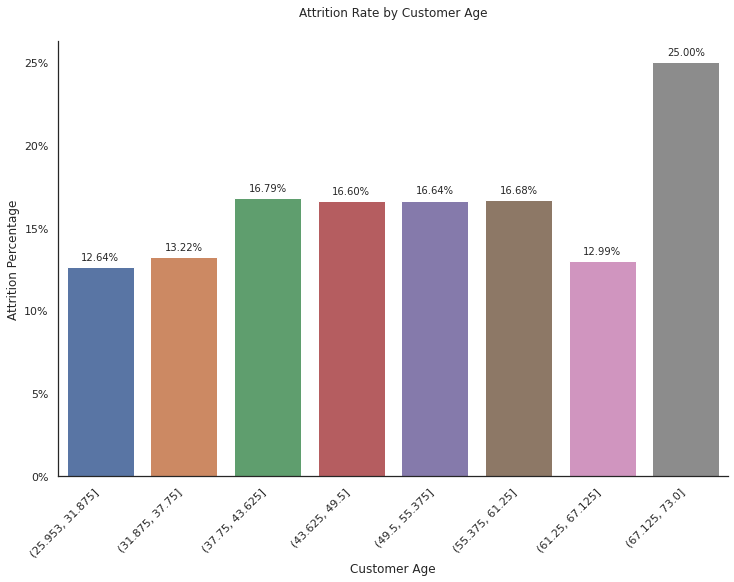




TESTING

'Customer Age' is grouped for testing by '< 45' and '>= 45'.



attrition_flag,total_customers,attrited_customers,existing_customers,attrition_percent
customer_age,,,,
< 45,4175,649,3526,15.54
>= 45,5952,978,4974,16.43


<Figure size 576x576 with 0 Axes>

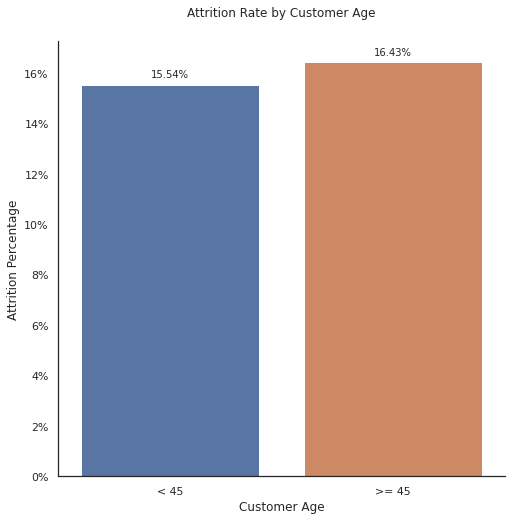


'Customer Age' testing results:

Z-Test:
The p-value for 'customer age' is 0.232, therefore we can ACCEPT the null hypothesis.

Mean:
The average 'customer age' for Existing Customers is 46.26.
The average 'customer age' for Attrited Customers is 46.66.

T-Test:
The p-value for 'customer age' is 0.067, therefore we can ACCEPT the null hypothesis.



In [8]:
######################################
############### DEFINE ###############
######################################
## define column name for preview and testing
column_name = 'customer_age'


#######################################
############### PREVIEW ###############
#######################################
## DEFINE 
### number of preview bins
num_bins = max_bins()

## FORMAT
### PREVIEW PLOT size, label angle, label alignment (generally 3+ groups)
plot_width_prev, plot_height_prev = 12, 8
x_axis_ang_prev = 45
horiz_align_prev = 'right'


#######################################
############### TESTING ###############
#######################################
## TEST GROUPS
### DEFINE value being used to divide groups
less_than_num = 45
### data to exclude from ordinal groups -- default to no_exclusions()
exclude_plus = no_exclusions()

### DEFINE formatted labels for the 2 test groups -- if numeric; group_label_1 is 'less than' -- group_label_2 is 'greater than or equal to'
group_label_1 = '< 45'
group_label_2 = '>= 45'

### TEST PLOT size, label angle, label alignment (2 groups)
plot_width_test, plot_height_test = 8, 8
x_axis_ang_test = 0
horiz_align_test = 'center'


########################################
############### PRINTING ###############
########################################
## PRINT
print_num_preview()
print_num_test()


#############################################
############### DEFINE CONCAT ###############
#############################################
## DEFINE concatenated DataFrame
df_attrition_all = concat_func()

### Gender
> gender of the customer


PREVIEW DATA

'Gender' is separated into 2 preliminary groups as a preview of the data.



attrition_flag,total_customers,attrited_customers,existing_customers,attrition_percent
gender,,,,
Male,4769,697,4072,14.62
Female,5358,930,4428,17.36


<Figure size 576x576 with 0 Axes>

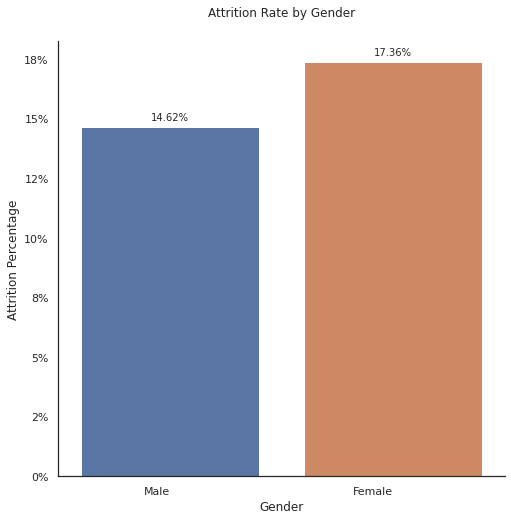




TESTING

'Gender' is grouped for testing by 'Male' and 'Female'.



attrition_flag,total_customers,attrited_customers,existing_customers,attrition_percent
gender,,,,
Male,4769,697,4072,14.62
Female,5358,930,4428,17.36


<Figure size 576x576 with 0 Axes>

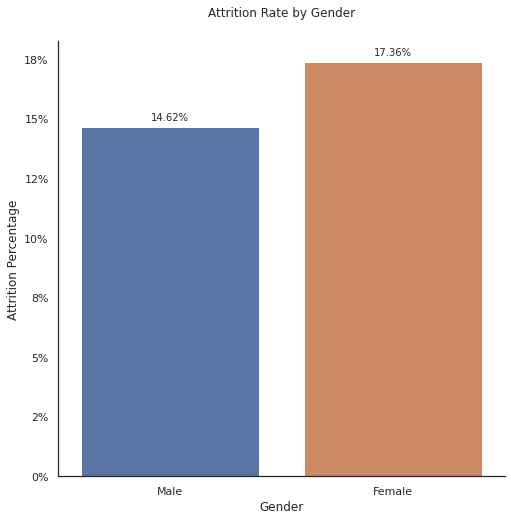


'Gender' testing results:

Z-Test:
The p-value for 'gender' is 1.747e-04, therefore we can REJECT the null hypothesis.

T-Test:
The data in this category is categorical, therefore no t-test could be performed.



In [9]:
######################################
############### DEFINE ###############
######################################
## define column name for preview and testing
column_name = 'gender'


########################################
############### GROUPING ###############
########################################
## grouping column variables in a hierarchical order
group_names = ['Male',
               'Female']

## FORMAT
### PREVIEW PLOT size, label angle, label alignment (generally 3+ groups)
plot_width_prev, plot_height_prev = 8, 8
x_axis_ang_prev = 0
horiz_align_prev = 'right'


#######################################
############### TESTING ###############
#######################################
## TEST GROUPS
### DEFINE value being used to divide groups
less_than_num = 1
### data to exclude from ordinal groups -- default to no_exclusions()
exclude_plus = no_exclusions()

### DEFINE formatted labels for the 2 test groups -- if numeric; group_label_1 is 'less than' -- group_label_2 is 'greater than or equal to'
group_label_1 = 'Male'
group_label_2 = 'Female'

### TEST PLOT size, label angle, label alignment (2 groups)
plot_width_test, plot_height_test = 8, 8
x_axis_ang_test = 0
horiz_align_test = 'center'


########################################
############### PRINTING ###############
########################################
## PRINT
cat_preview()
print_num_test()


#############################################
############### DEFINE CONCAT ###############
#############################################
## DEFINE concatenated DataFrame
df_attrition_all = concat_func()

### Dependent Count
> number of dependents customer is currently responsible for


PREVIEW DATA

'Dependent Count' is separated into 5 preliminary groups as a preview of the data.



attrition_flag,total_customers,attrited_customer,existing_customer,attrition_percent
dependent_count,,,,
"(-0.005, 1.0]",2742,404,2338,14.73
"(1.0, 2.0]",2655,417,2238,15.71
"(2.0, 3.0]",2732,482,2250,17.64
"(3.0, 4.0]",1574,260,1314,16.52
"(4.0, 5.0]",424,64,360,15.09


<Figure size 864x576 with 0 Axes>

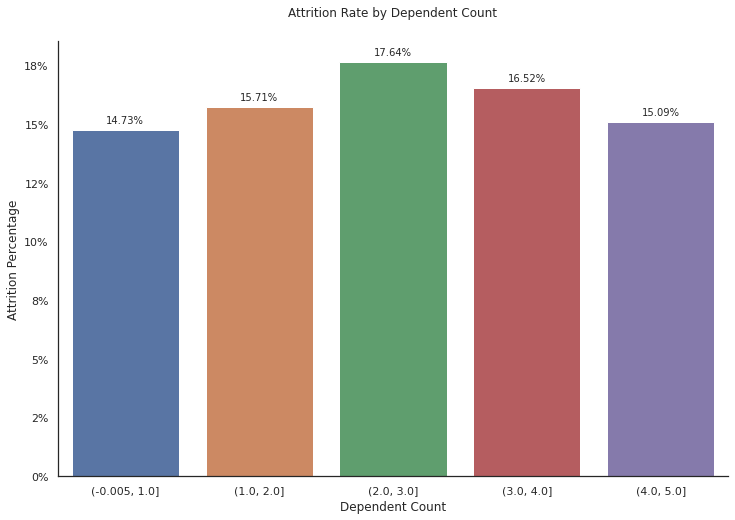




TESTING

'Dependent Count' is grouped for testing by '< 3' and '>= 3'.



attrition_flag,total_customers,attrited_customers,existing_customers,attrition_percent
dependent_count,,,,
< 3,5397,821,4576,15.21
>= 3,4730,806,3924,17.04


<Figure size 576x576 with 0 Axes>

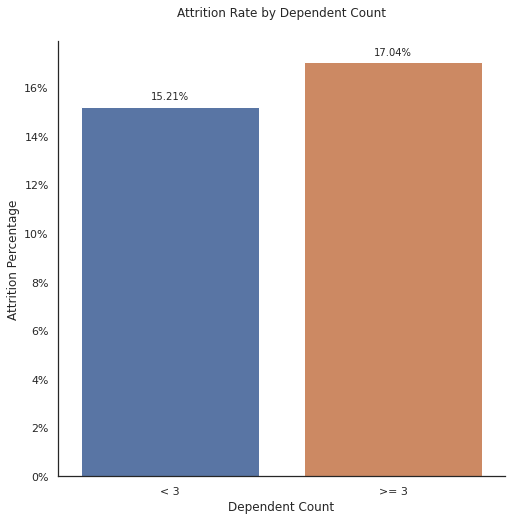


'Dependent Count' testing results:

Z-Test:
The p-value for 'dependent count' is 0.012, therefore we can REJECT the null hypothesis.

Mean:
The average 'dependent count' for Existing Customers is 2.34.
The average 'dependent count' for Attrited Customers is 2.40.

T-Test:
The p-value for 'dependent count' is 0.056, therefore we can ACCEPT the null hypothesis.



In [10]:
######################################
############### DEFINE ###############
######################################
## define column name for preview and testing
column_name = 'dependent_count'


#######################################
############### PREVIEW ###############
#######################################
## DEFINE 
### number of preview bins
num_bins = max_bins()

## FORMAT
### PREVIEW PLOT size, label angle, label alignment (generally 3+ groups)
plot_width_prev, plot_height_prev = 12, 8
x_axis_ang_prev = 0
horiz_align_prev = 'center'


#######################################
############### TESTING ###############
#######################################
## TEST GROUPS
### DEFINE value being used to divide groups
less_than_num = 3
### data to exclude from ordinal groups -- default to no_exclusions()
exclude_plus = no_exclusions()

## DEFINE formatted labels for the 2 test groups -- if numeric; group_label_1 is 'less than' -- group_label_2 is 'greater than or equal to'
group_label_1 = '< 3'
group_label_2 = '>= 3'

## TEST PLOT size, label angle, label alignment (2 groups)
plot_width_test, plot_height_test = 8, 8
x_axis_ang_test = 0
horiz_align_test = 'center'


########################################
############### PRINTING ###############
########################################
## PRINT
print_num_preview()
print_num_test()


#############################################
############### DEFINE CONCAT ###############
#############################################
## DEFINE concatenated DataFrame
df_attrition_all = concat_func()

### Education
> highest education level achieved by the customer


PREVIEW DATA

'Education Level' is separated into 7 preliminary groups as a preview of the data.



attrition_flag,total_customers,attrited_customers,existing_customers,attrition_percent
education_level,,,,
Uneducated,1487,237,1250,15.94
High School,2013,306,1707,15.20
College,1013,154,859,15.20
Graduate,3128,487,2641,15.57
Post-Graduate,516,92,424,17.83
Doctorate,451,95,356,21.06
Unknown,1519,256,1263,16.85


<Figure size 864x576 with 0 Axes>

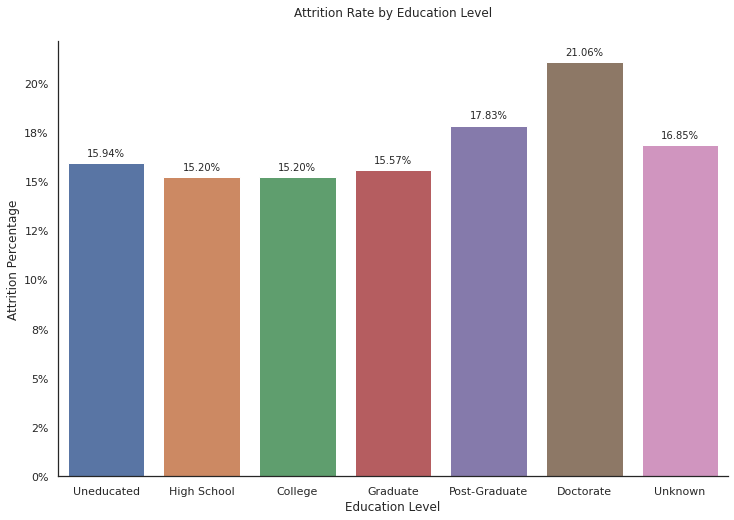




TESTING

'Education Level' is grouped for testing by 'College Degree or Less' and 'Graduate Degree or Higher'.



attrition_flag,total_customers,attrited_customers,existing_customers,attrition_percent
education_level,,,,
College Degree or Less,4513,697,3816,15.44
Graduate Degree or Higher,4095,674,3421,16.46


<Figure size 576x576 with 0 Axes>

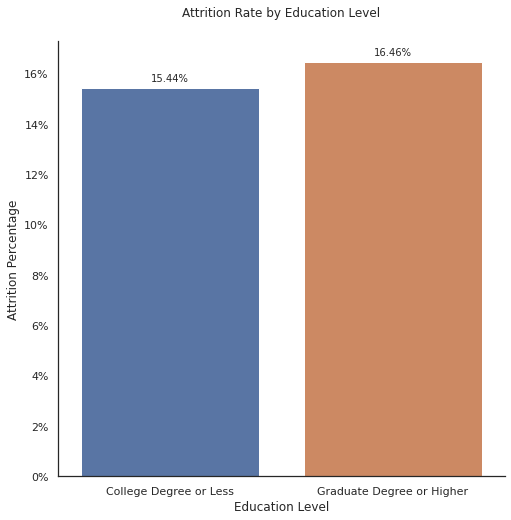


'Education Level' testing results:

Z-Test:
The p-value for 'education level' is 0.127, therefore we can ACCEPT the null hypothesis.

T-Test:
The data in this category is categorical, therefore no t-test could be performed.



In [11]:
######################################
############### DEFINE ###############
######################################
## define column name for preview and testing
column_name = 'education_level'


########################################
############### GROUPING ###############
########################################
## grouping column variables in a hierarchical order
group_names = ['Uneducated',
               'High School',
               'College',
               'Graduate',
               'Post-Graduate',
               'Doctorate',
               'Unknown']

## FORMAT
### PREVIEW PLOT size, label angle, label alignment (generally 3+ groups)
plot_width_prev, plot_height_prev = 12, 8
x_axis_ang_prev = 0
horiz_align_prev = 'center'


#######################################
############### TESTING ###############
#######################################
## TEST GROUPS
### DEFINE value being used to divide groups
less_than_num = 3
### data to exclude from ordinal groups -- default to no_exclusions()
exclude_plus = 6

### DEFINE formatted labels for the 2 test groups -- if numeric; group_label_1 is 'less than' -- group_label_2 is 'greater than or equal to'
group_label_1 = 'College Degree or Less'
group_label_2 = 'Graduate Degree or Higher'

### TEST PLOT size, label angle, label alignment (2 groups)
plot_width_test, plot_height_test = 8, 8
x_axis_ang_test = 0
horiz_align_test = 'center'


########################################
############### PRINTING ###############
########################################
## PRINT
cat_preview()
print_num_test()


#############################################
############### DEFINE CONCAT ###############
#############################################
## DEFINE concatenated DataFrame
df_attrition_all = concat_func()

### Marital Status
> current marriage status of the customer


PREVIEW DATA

'Marital Status' is separated into 4 preliminary groups as a preview of the data.



attrition_flag,total_customers,attrited_customers,existing_customers,attrition_percent
marital_status,,,,
Single,3943,668,3275,16.94
Divorced,748,121,627,16.18
Married,4687,709,3978,15.13
Unknown,749,129,620,17.22


<Figure size 864x576 with 0 Axes>

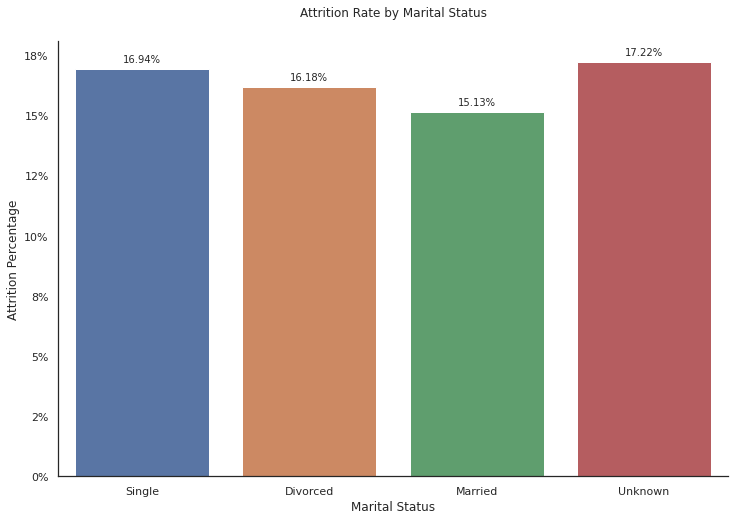




TESTING

'Marital Status' is grouped for testing by 'Single or Divorced' and 'Married'.



attrition_flag,total_customers,attrited_customers,existing_customers,attrition_percent
marital_status,,,,
Single or Divorced,4691,789,3902,16.82
Married,4687,709,3978,15.13


<Figure size 576x576 with 0 Axes>

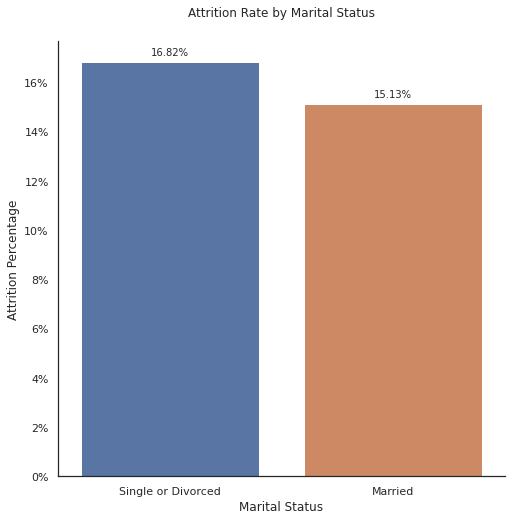


'Marital Status' testing results:

Z-Test:
The p-value for 'marital status' is 0.055, therefore we can ACCEPT the null hypothesis.

T-Test:
The data in this category is categorical, therefore no t-test could be performed.



In [12]:
######################################
############### DEFINE ###############
######################################
## define column name for preview and testing
column_name = 'marital_status'


########################################
############### GROUPING ###############
########################################
## grouping column variables in a hierarchical order
group_names = ['Single',
               'Divorced',
               'Married',
               'Unknown']


#######################################
############### TESTING ###############
#######################################
## TEST GROUPS
### DEFINE value being used to divide groups
less_than_num = 2
### data to exclude from ordinal groups -- default to no_exclusions()
exclude_plus = 3

### DEFINE formatted labels for the 2 test groups -- if numeric; group_label_1 is 'less than' -- group_label_2 is 'greater than or equal to'
group_label_1 = 'Single or Divorced'
group_label_2 = 'Married'

### TEST PLOT size, label angle, label alignment (2 groups)
plot_width_test, plot_height_test = 8, 8
x_axis_ang_test = 0
horiz_align_test = 'center'


########################################
############### PRINTING ###############
########################################
## PRINT
cat_preview()
print_num_test()


#############################################
############### DEFINE CONCAT ###############
#############################################
## DEFINE concatenated DataFrame
df_attrition_all = concat_func()

### Income Category
> current income level of the customer


PREVIEW DATA

'Income Category' is separated into 6 preliminary groups as a preview of the data.



attrition_flag,total_customers,attrited_customers,existing_customers,attrition_percent
income_category,,,,
Less than $40K,3561,612,2949,17.19
$40K - $60K,1790,271,1519,15.14
$60K - $80K,1402,189,1213,13.48
$80K - $120K,1535,242,1293,15.77
$120K +,727,126,601,17.33
Unknown,1112,187,925,16.82


<Figure size 864x576 with 0 Axes>

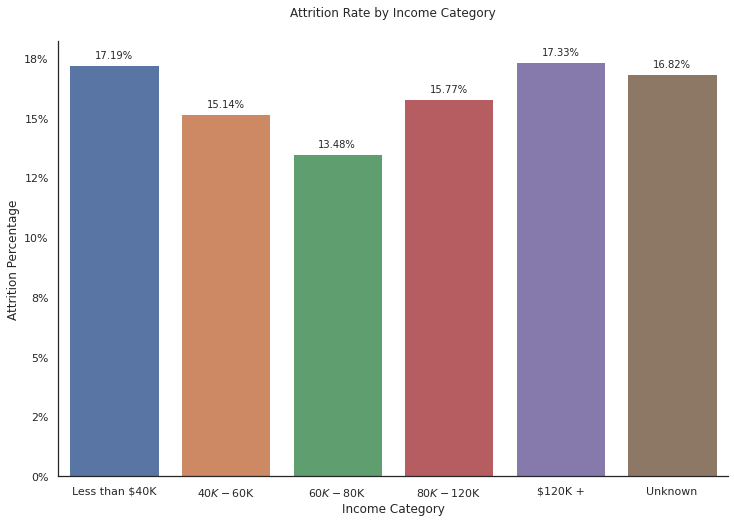




TESTING

'Income Category' is grouped for testing by '< $40K' and '>= $40K'.



attrition_flag,total_customers,attrited_customers,existing_customers,attrition_percent
income_category,,,,
< $40K,3561,612,2949,17.19
>= $40K,5454,828,4626,15.18


<Figure size 576x576 with 0 Axes>

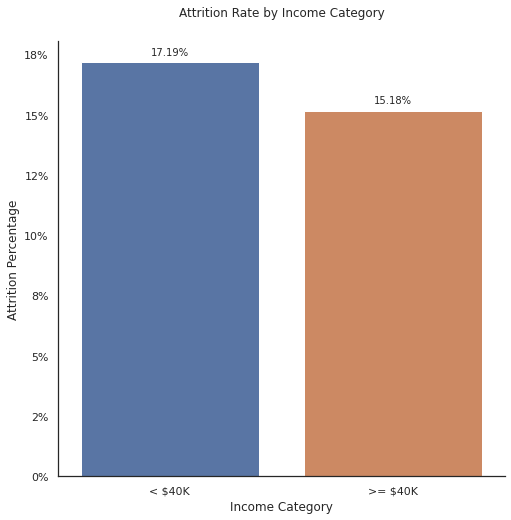


'Income Category' testing results:

Z-Test:
The p-value for 'income category' is 0.024, therefore we can REJECT the null hypothesis.

T-Test:
The data in this category is categorical, therefore no t-test could be performed.



In [13]:
######################################
############### DEFINE ###############
######################################
## define column name for preview and testing
column_name = 'income_category'


########################################
############### GROUPING ###############
########################################
## grouping column variables in a hierarchical order
group_names = ['Less than $40K',
               '$40K - $60K',
               '$60K - $80K',
               '$80K - $120K',
               '$120K +',
               'Unknown']


#######################################
############### TESTING ###############
#######################################
## TEST GROUPS
### DEFINE value being used to divide groups
less_than_num = 1
### data to exclude from ordinal groups -- default to no_exclusions()
exclude_plus = 5

### DEFINE formatted labels for the 2 test groups -- if numeric; group_label_1 is 'less than' -- group_label_2 is 'greater than or equal to'
group_label_1 = '< $40K'
group_label_2 = '>= $40K'

### TEST PLOT size, label angle, label alignment (2 groups)
plot_width_test, plot_height_test = 8, 8
x_axis_ang_test = 0
horiz_align_test = 'center'


########################################
############### PRINTING ###############
########################################
## PRINT
cat_preview()
print_num_test()


#############################################
############### DEFINE CONCAT ###############
#############################################
## DEFINE concatenated DataFrame
df_attrition_all = concat_func()

### Card Category
> Tier of card held by customer.


PREVIEW DATA

'Card Category' is separated into 4 preliminary groups as a preview of the data.



attrition_flag,total_customers,attrited_customers,existing_customers,attrition_percent
card_category,,,,
Blue,9436,1519,7917,16.10
Silver,555,82,473,14.77
Gold,116,21,95,18.10
Platinum,20,5,15,25.00


<Figure size 864x576 with 0 Axes>

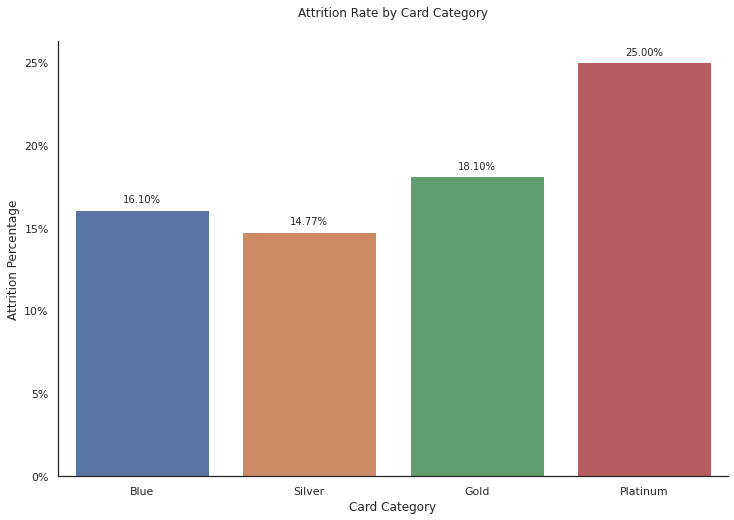




TESTING

'Card Category' is grouped for testing by 'Blue' and 'Silver/Gold/Platinum'.



attrition_flag,total_customers,attrited_customers,existing_customers,attrition_percent
card_category,,,,
Blue,9436,1519,7917,16.10
Silver/Gold/Platinum,691,108,583,15.63


<Figure size 576x576 with 0 Axes>

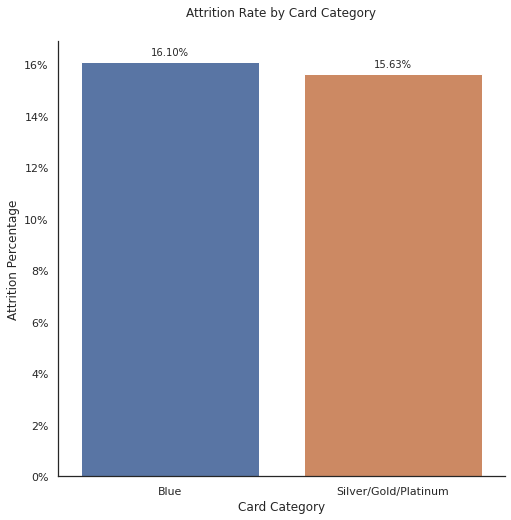


'Card Category' testing results:

Z-Test:
The p-value for 'card category' is 0.746, therefore we can ACCEPT the null hypothesis.

T-Test:
The data in this category is categorical, therefore no t-test could be performed.



In [14]:
######################################
############### DEFINE ###############
######################################
## define column name for preview and testing
column_name = 'card_category'


########################################
############### GROUPING ###############
########################################
## grouping column variables in a hierarchical order
group_names = ['Blue',
               'Silver',
               'Gold',
               'Platinum']


#######################################
############### TESTING ###############
#######################################
## TEST GROUPS
### DEFINE value being used to divide groups
less_than_num = 1
### data to exclude from ordinal groups -- default to no_exclusions()
exclude_plus = no_exclusions()

### DEFINE formatted labels for the 2 test groups -- if numeric; group_label_1 is 'less than' -- group_label_2 is 'greater than or equal to'
group_label_1 = 'Blue'
group_label_2 = 'Silver/Gold/Platinum'

### TEST PLOT size, label angle, label alignment (2 groups)
plot_width_test, plot_height_test = 8, 8
x_axis_ang_test = 0
horiz_align_test = 'center'


########################################
############### PRINTING ###############
########################################
## PRINT
cat_preview()
print_num_test()


#############################################
############### DEFINE CONCAT ###############
#############################################
## DEFINE concatenated DataFrame
df_attrition_all = concat_func()

### Months On Book
> number of months customer has been with the bank overall


PREVIEW DATA

'Months On Book' is separated into 8 preliminary groups as a preview of the data.



attrition_flag,total_customers,attrited_customer,existing_customer,attrition_percent
months_on_book,,,,
"(12.957, 18.375]",246,37,209,15.04
"(18.375, 23.75]",441,61,380,13.83
"(23.75, 29.125]",1233,183,1050,14.84
"(29.125, 34.5]",1565,241,1324,15.40
"(34.5, 39.875]",3826,658,3168,17.20
"(39.875, 45.25]",1631,249,1382,15.27
"(45.25, 50.625]",767,136,631,17.73
"(50.625, 56.0]",418,62,356,14.83


<Figure size 864x576 with 0 Axes>

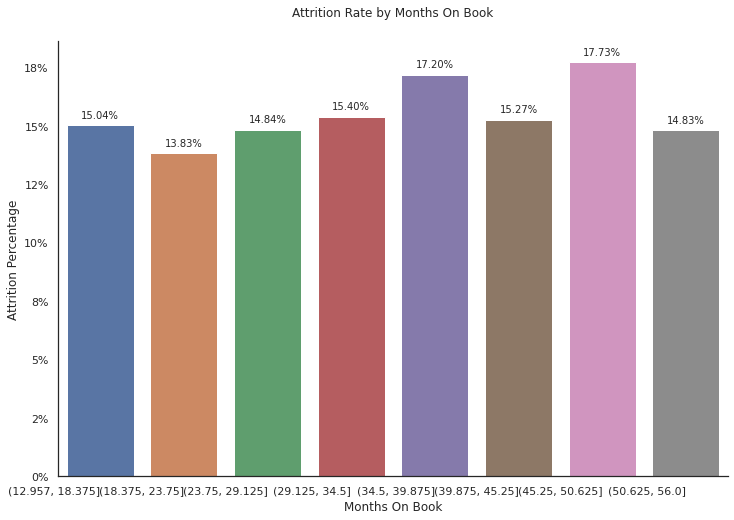




TESTING

'Months On Book' is grouped for testing by '< 36' and '>= 36'.



attrition_flag,total_customers,attrited_customers,existing_customers,attrition_percent
months_on_book,,,,
< 36,3802,567,3235,14.91
>= 36,6325,1060,5265,16.76


<Figure size 576x576 with 0 Axes>

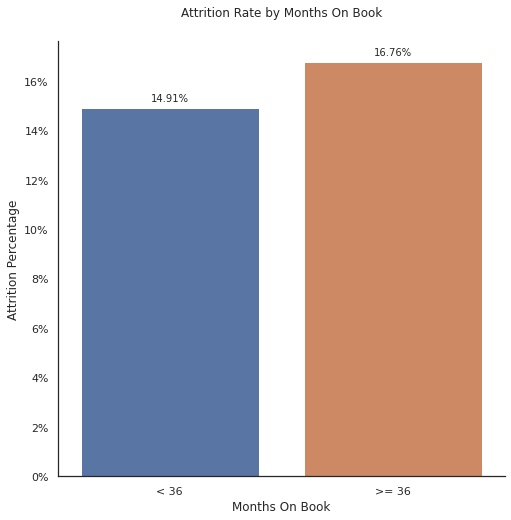


'Months On Book' testing results:

Z-Test:
The p-value for 'months on book' is 0.014, therefore we can REJECT the null hypothesis.

Mean:
The average 'months on book' for Existing Customers is 35.88.
The average 'months on book' for Attrited Customers is 36.18.

T-Test:
The p-value for 'months on book' is 0.168, therefore we can ACCEPT the null hypothesis.



In [15]:
######################################
############### DEFINE ###############
######################################
## define column name for preview and testing
column_name = 'months_on_book'


#######################################
############### PREVIEW ###############
#######################################
## DEFINE 
### number of preview bins
num_bins = max_bins()

## FORMAT
### PREVIEW PLOT size, label angle, label alignment (generally 3+ groups)
plot_width_prev, plot_height_prev = 12, 8
x_axis_ang_prev = 0
horiz_align_prev = 'right'


#######################################
############### TESTING ###############
#######################################
## TEST GROUPS
### DEFINE value being used to divide groups
less_than_num = 36
### data to exclude from ordinal groups -- default to no_exclusions()
exclude_plus = no_exclusions()

## DEFINE formatted labels for the 2 test groups -- if numeric; group_label_1 is 'less than' -- group_label_2 is 'greater than or equal to'
group_label_1 = '< 36'
group_label_2 = '>= 36'

## TEST PLOT size, label angle, label alignment (2 groups)
plot_width_test, plot_height_test = 8, 8
x_axis_ang_test = 0
horiz_align_test = 'center'


########################################
############### PRINTING ###############
########################################
## PRINT
print_num_preview()
print_num_test()


#############################################
############### DEFINE CONCAT ###############
#############################################
## DEFINE concatenated DataFrame
df_attrition_all = concat_func()

### Total Relationship Count
> total number of products held by the customer


PREVIEW DATA

'Total Relationship Count' is separated into 6 preliminary groups as a preview of the data.



attrition_flag,total_customers,attrited_customer,existing_customer,attrition_percent
total_relationship_count,,,,
"(0.995, 1.833]",910,233,677,25.60
"(1.833, 2.667]",1243,346,897,27.84
"(2.667, 3.5]",2305,400,1905,17.35
"(3.5, 4.333]",1912,225,1687,11.77
"(4.333, 5.167]",1891,227,1664,12.00
"(5.167, 6.0]",1866,196,1670,10.50


<Figure size 864x576 with 0 Axes>

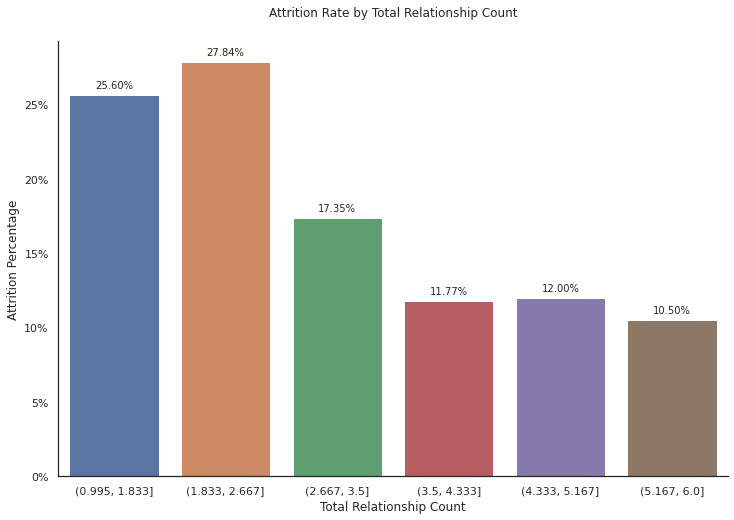




TESTING

'Total Relationship Count' is grouped for testing by '< 4' and '>= 4'.



attrition_flag,total_customers,attrited_customers,existing_customers,attrition_percent
total_relationship_count,,,,
< 4,4458,979,3479,21.96
>= 4,5669,648,5021,11.43


<Figure size 576x576 with 0 Axes>

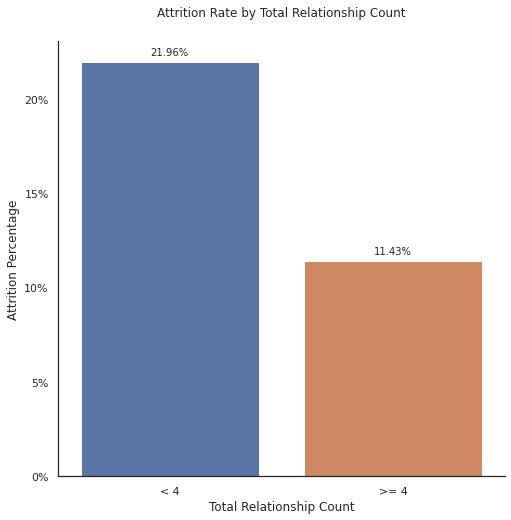


'Total Relationship Count' testing results:

Z-Test:
The p-value for 'total relationship count' is 1.857e-47, therefore we can REJECT the null hypothesis.

Mean:
The average 'total relationship count' for Existing Customers is 3.91.
The average 'total relationship count' for Attrited Customers is 3.28.

T-Test:
The p-value for 'total relationship count' is 4.829e-52, therefore we can REJECT the null hypothesis.



In [16]:
######################################
############### DEFINE ###############
######################################
## define column name for preview and testing
column_name = 'total_relationship_count'


#######################################
############### PREVIEW ###############
#######################################
## DEFINE 
### number of preview bins
num_bins = max_bins()

## FORMAT
### PREVIEW PLOT size, label angle, label alignment (generally 3+ groups)
plot_width_prev, plot_height_prev = 12, 8
x_axis_ang_prev = 0
horiz_align_prev = 'center'


#######################################
############### TESTING ###############
#######################################
## TEST GROUPS
### DEFINE value being used to divide groups
less_than_num = 4
### data to exclude from ordinal groups -- default to no_exclusions()
exclude_plus = no_exclusions()

## DEFINE formatted labels for the 2 test groups -- if numeric; group_label_1 is 'less than' -- group_label_2 is 'greater than or equal to'
group_label_1 = '< 4'
group_label_2 = '>= 4'

## TEST PLOT size, label angle, label alignment (2 groups)
plot_width_test, plot_height_test = 8, 8
x_axis_ang_test = 0
horiz_align_test = 'center'


########################################
############### PRINTING ###############
########################################
## PRINT
print_num_preview()
print_num_test()


#############################################
############### DEFINE CONCAT ###############
#############################################
## DEFINE concatenated DataFrame
df_attrition_all = concat_func()

### Months Inactive 12 Mon
> number of inacitve months over past 12 months


PREVIEW DATA

'Months Inactive 12 Mon' is separated into 6 preliminary groups as a preview of the data.



attrition_flag,total_customers,attrited_customer,existing_customer,attrition_percent
months_inactive_12_mon,,,,
"(-0.006, 1.0]",2262,115,2147,5.08
"(1.0, 2.0]",3282,505,2777,15.39
"(2.0, 3.0]",3846,826,3020,21.48
"(3.0, 4.0]",435,130,305,29.89
"(4.0, 5.0]",178,32,146,17.98
"(5.0, 6.0]",124,19,105,15.32


<Figure size 864x576 with 0 Axes>

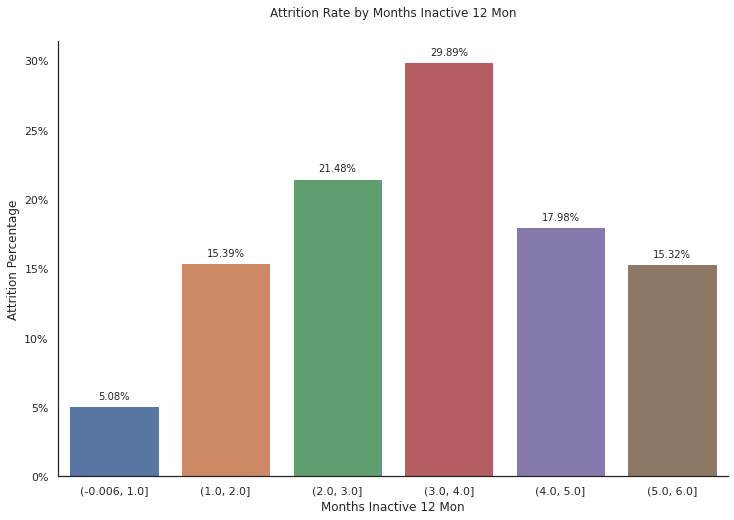




TESTING

'Months Inactive 12 Mon' is grouped for testing by '< 3' and '>= 3'.



attrition_flag,total_customers,attrited_customers,existing_customers,attrition_percent
months_inactive_12_mon,,,,
< 3,5544,620,4924,11.18
>= 3,4583,1007,3576,21.97


<Figure size 576x576 with 0 Axes>

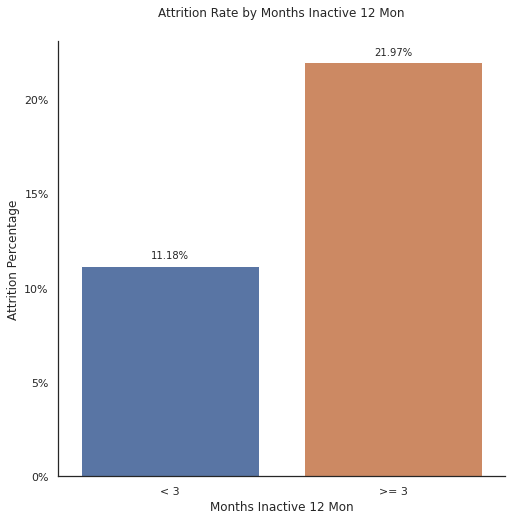


'Months Inactive 12 Mon' testing results:

Z-Test:
The p-value for 'months inactive 12 mon' is 4.767e-50, therefore we can REJECT the null hypothesis.

Mean:
The average 'months inactive 12 mon' for Existing Customers is 2.27.
The average 'months inactive 12 mon' for Attrited Customers is 2.69.

T-Test:
The p-value for 'months inactive 12 mon' is 1.033e-53, therefore we can REJECT the null hypothesis.



In [17]:
######################################
############### DEFINE ###############
######################################
## define column name for preview and testing
column_name = 'months_inactive_12_mon'


#######################################
############### PREVIEW ###############
#######################################
## DEFINE 
### number of preview bins
num_bins = max_bins()

## FORMAT
### PREVIEW PLOT size, label angle, label alignment (generally 3+ groups)
plot_width_prev, plot_height_prev = 12, 8
x_axis_ang_prev = 0
horiz_align_prev = 'center'


#######################################
############### TESTING ###############
#######################################
## TEST GROUPS
### DEFINE value being used to divide groups
less_than_num = 3
### data to exclude from ordinal groups -- default to no_exclusions()
exclude_plus = no_exclusions()

## DEFINE formatted labels for the 2 test groups -- if numeric; group_label_1 is 'less than' -- group_label_2 is 'greater than or equal to'
group_label_1 = '< 3'
group_label_2 = '>= 3'

## TEST PLOT size, label angle, label alignment (2 groups)
plot_width_test, plot_height_test = 8, 8
x_axis_ang_test = 0
horiz_align_test = 'center'


########################################
############### PRINTING ###############
########################################
## PRINT
print_num_preview()
print_num_test()


#############################################
############### DEFINE CONCAT ###############
#############################################
## DEFINE concatenated DataFrame
df_attrition_all = concat_func()

### Contacts Count 12 Mon
> number of contacts with the bank over the past 12 months


PREVIEW DATA

'Contacts Count 12 Mon' is separated into 6 preliminary groups as a preview of the data.



attrition_flag,total_customers,attrited_customer,existing_customer,attrition_percent
contacts_count_12_mon,,,,
"(-0.006, 1.0]",1898,115,1783,6.06
"(1.0, 2.0]",3227,403,2824,12.49
"(2.0, 3.0]",3380,681,2699,20.15
"(3.0, 4.0]",1392,315,1077,22.63
"(4.0, 5.0]",176,59,117,33.52
"(5.0, 6.0]",54,54,0,100.00


<Figure size 864x576 with 0 Axes>

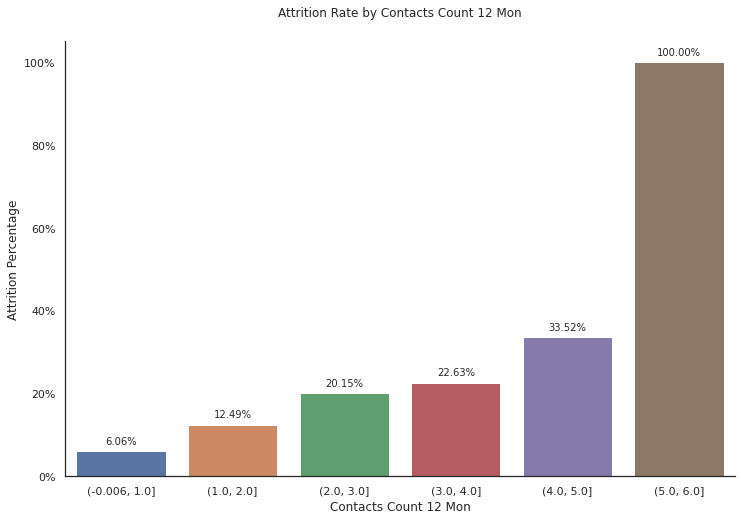




TESTING

'Contacts Count 12 Mon' is grouped for testing by '< 3' and '>= 3'.



attrition_flag,total_customers,attrited_customers,existing_customers,attrition_percent
contacts_count_12_mon,,,,
< 3,5125,518,4607,10.11
>= 3,5002,1109,3893,22.17


<Figure size 576x576 with 0 Axes>

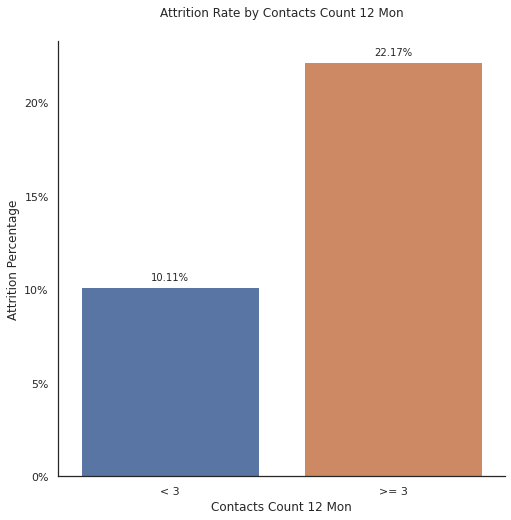


'Contacts Count 12 Mon' testing results:

Z-Test:
The p-value for 'contacts count 12 mon' is 5.234e-63, therefore we can REJECT the null hypothesis.

Mean:
The average 'contacts count 12 mon' for Existing Customers is 2.36.
The average 'contacts count 12 mon' for Attrited Customers is 2.97.

T-Test:
The p-value for 'contacts count 12 mon' is 4.697e-96, therefore we can REJECT the null hypothesis.



In [18]:
######################################
############### DEFINE ###############
######################################
## define column name for preview and testing
column_name = 'contacts_count_12_mon'


#######################################
############### PREVIEW ###############
#######################################
## DEFINE 
### number of preview bins
num_bins = max_bins()

## FORMAT
### PREVIEW PLOT size, label angle, label alignment (generally 3+ groups)
plot_width_prev, plot_height_prev = 12, 8
x_axis_ang_prev = 0
horiz_align_prev = 'center'


#######################################
############### TESTING ###############
#######################################
## TEST GROUPS
### DEFINE value being used to divide groups
less_than_num = 3
### data to exclude from ordinal groups -- default to no_exclusions()
exclude_plus = no_exclusions()

## DEFINE formatted labels for the 2 test groups -- if numeric; group_label_1 is 'less than' -- group_label_2 is 'greater than or equal to'
group_label_1 = '< 3'
group_label_2 = '>= 3'

## TEST PLOT size, label angle, label alignment (2 groups)
plot_width_test, plot_height_test = 8, 8
x_axis_ang_test = 0
horiz_align_test = 'center'


########################################
############### PRINTING ###############
########################################
## PRINT
print_num_preview()
print_num_test()


#############################################
############### DEFINE CONCAT ###############
#############################################
## DEFINE concatenated DataFrame
df_attrition_all = concat_func()

### Credit Limit
> credit limit on the credit card


PREVIEW DATA

'Credit Limit' is separated into 8 preliminary groups as a preview of the data.



attrition_flag,total_customers,attrited_customer,existing_customer,attrition_percent
credit_limit,,,,
"(1405.222, 5573.012]",5703,970,4733,17.01
"(5573.012, 9707.725]",1567,242,1325,15.44
"(9707.725, 13842.437]",879,135,744,15.36
"(13842.437, 17977.15]",513,71,442,13.84
"(17977.15, 22111.862]",375,37,338,9.87
"(22111.862, 26246.575]",263,40,223,15.21
"(26246.575, 30381.287]",176,25,151,14.20
"(30381.287, 34516.0]",651,107,544,16.44


<Figure size 864x576 with 0 Axes>

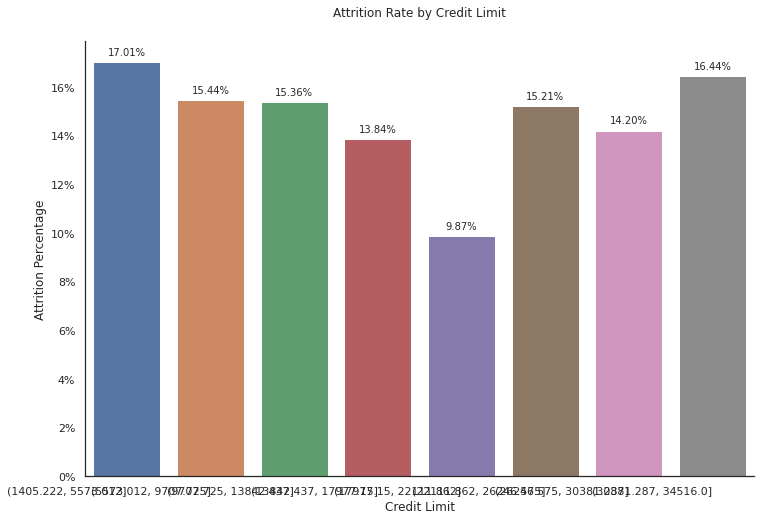




TESTING

'Credit Limit' is grouped for testing by '< $5,000' and '>= $5,000'.



attrition_flag,total_customers,attrited_customers,existing_customers,attrition_percent
credit_limit,,,,
"< $5,000",5358,926,4432,17.28
">= $5,000",4769,701,4068,14.70


<Figure size 576x576 with 0 Axes>

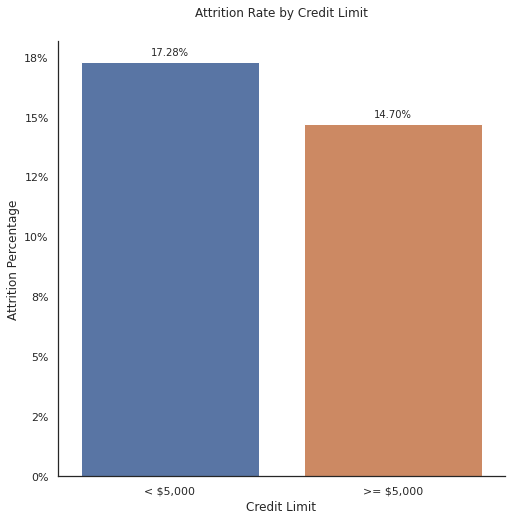


'Credit Limit' testing results:

Z-Test:
The p-value for 'credit limit' is 4.066e-04, therefore we can REJECT the null hypothesis.

Mean:
The average 'credit limit' for Existing Customers is 8726.88.
The average 'credit limit' for Attrited Customers is 8136.04.

T-Test:
The p-value for 'credit limit' is 0.016, therefore we can REJECT the null hypothesis.



In [19]:
######################################
############### DEFINE ###############
######################################
## define column name for preview and testing
column_name = 'credit_limit'


#######################################
############### PREVIEW ###############
#######################################
## DEFINE 
### number of preview bins
num_bins = max_bins()

## FORMAT
### PREVIEW PLOT size, label angle, label alignment (generally 3+ groups)
plot_width_prev, plot_height_prev = 12, 8
x_axis_ang_prev = 0
horiz_align_prev = 'right'


#######################################
############### TESTING ###############
#######################################
## TEST GROUPS
### DEFINE value being used to divide groups
less_than_num = 5000
### data to exclude from ordinal groups -- default to no_exclusions()
exclude_plus = no_exclusions()

## DEFINE formatted labels for the 2 test groups -- if numeric; group_label_1 is 'less than' -- group_label_2 is 'greater than or equal to'
group_label_1 = '< $5,000'
group_label_2 = '>= $5,000'

## TEST PLOT size, label angle, label alignment (2 groups)
plot_width_test, plot_height_test = 8, 8
x_axis_ang_test = 0
horiz_align_test = 'center'


########################################
############### PRINTING ###############
########################################
## PRINT
print_num_preview()
print_num_test()


#############################################
############### DEFINE CONCAT ###############
#############################################
## DEFINE concatenated DataFrame
df_attrition_all = concat_func()

### Total Revolving Bal
> unpaid balance remaining on card at end of billing cycle


PREVIEW DATA

'Total Revolving Bal' is separated into 8 preliminary groups as a preview of the data.



attrition_flag,total_customers,attrited_customer,existing_customer,attrition_percent
total_revolving_bal,,,,
"(-2.517, 314.625]",2516,939,1577,37.32
"(314.625, 629.25]",245,108,137,44.08
"(629.25, 943.875]",937,94,843,10.03
"(943.875, 1258.5]",1281,72,1209,5.62
"(1258.5, 1573.125]",1575,67,1508,4.25
"(1573.125, 1887.75]",1480,71,1409,4.80
"(1887.75, 2202.375]",1007,49,958,4.87
"(2202.375, 2517.0]",1086,227,859,20.90


<Figure size 864x576 with 0 Axes>

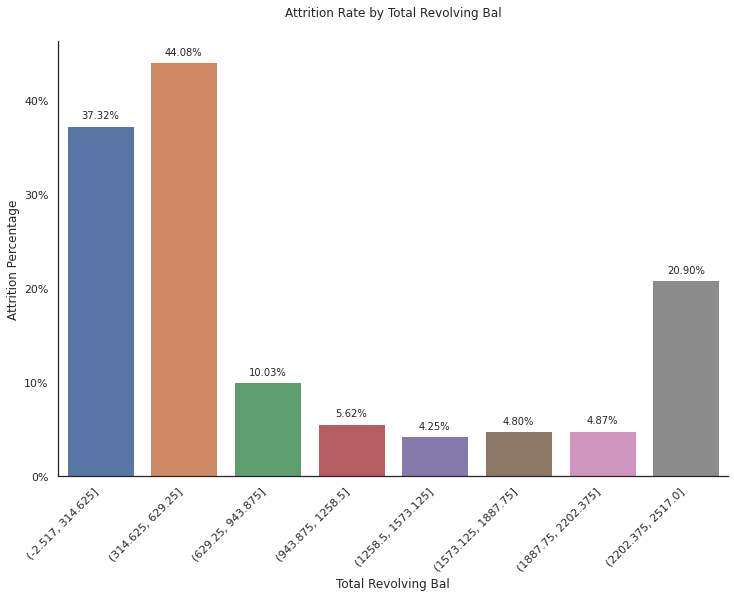




TESTING

'Total Revolving Bal' is grouped for testing by '< $1,250' and '>= $1,250'.



attrition_flag,total_customers,attrited_customers,existing_customers,attrition_percent
total_revolving_bal,,,,
"< $1,250",4921,1211,3710,24.61
">= $1,250",5206,416,4790,7.99


<Figure size 576x576 with 0 Axes>

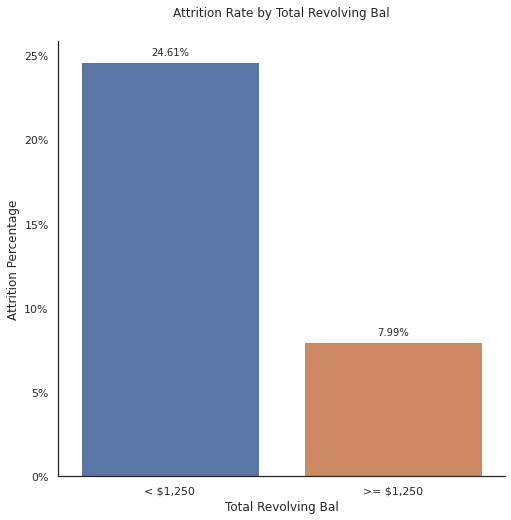


'Total Revolving Bal' testing results:

Z-Test:
The p-value for 'total revolving bal' is 9.825e-121, therefore we can REJECT the null hypothesis.

Mean:
The average 'total revolving bal' for Existing Customers is 1256.60.
The average 'total revolving bal' for Attrited Customers is 672.82.

T-Test:
The p-value for 'total revolving bal' is 6.630e-160, therefore we can REJECT the null hypothesis.



In [20]:
######################################
############### DEFINE ###############
######################################
## define column name for preview and testing
column_name = 'total_revolving_bal'


#######################################
############### PREVIEW ###############
#######################################
## DEFINE 
### number of preview bins
num_bins = max_bins()

## FORMAT
### PREVIEW PLOT size, label angle, label alignment (generally 3+ groups)
plot_width_prev, plot_height_prev = 12, 8
x_axis_ang_prev = 45
horiz_align_prev = 'right'


#######################################
############### TESTING ###############
#######################################
## TEST GROUPS
### DEFINE value being used to divide groups
less_than_num = 1250
### data to exclude from ordinal groups -- default to no_exclusions()
exclude_plus = no_exclusions()

## DEFINE formatted labels for the 2 test groups -- if numeric; group_label_1 is 'less than' -- group_label_2 is 'greater than or equal to'
group_label_1 = '< $1,250'
group_label_2 = '>= $1,250'

## TEST PLOT size, label angle, label alignment (2 groups)
plot_width_test, plot_height_test = 8, 8
x_axis_ang_test = 0
horiz_align_test = 'center'


########################################
############### PRINTING ###############
########################################
## PRINT
print_num_preview()
print_num_test()


#############################################
############### DEFINE CONCAT ###############
#############################################
## DEFINE concatenated DataFrame
df_attrition_all = concat_func()

### Avg Open To Buy
> average available balance over past 12 months


PREVIEW DATA

'Avg Open To Buy' is separated into 8 preliminary groups as a preview of the data.



attrition_flag,total_customers,attrited_customer,existing_customer,attrition_percent
avg_open_to_buy,,,,
"(-31.513, 4317.125]",5612,908,4704,16.18
"(4317.125, 8631.25]",1680,279,1401,16.61
"(8631.25, 12945.375]",872,156,716,17.89
"(12945.375, 17259.5]",548,74,474,13.50
"(17259.5, 21573.625]",367,40,327,10.90
"(21573.625, 25887.75]",251,37,214,14.74
"(25887.75, 30201.875]",181,26,155,14.36
"(30201.875, 34516.0]",616,107,509,17.37


<Figure size 864x576 with 0 Axes>

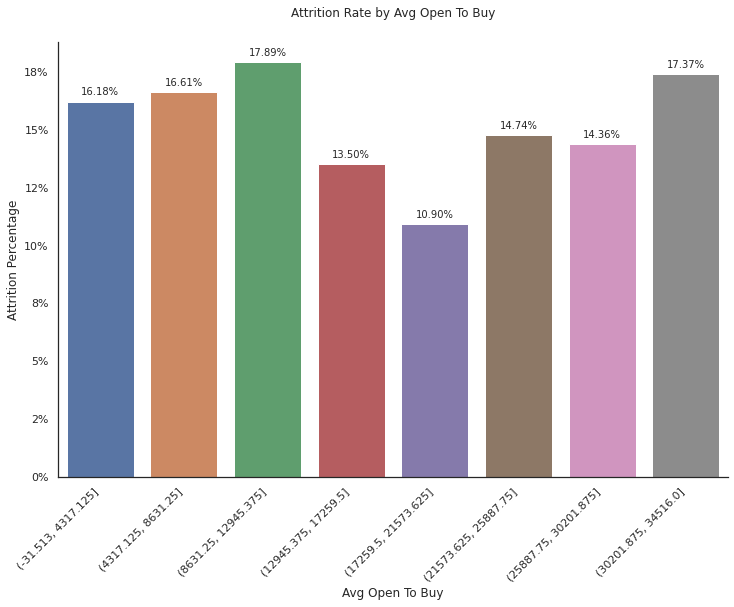




TESTING

'Avg Open To Buy' is grouped for testing by '< $5,000' and '>= $5,000'.



attrition_flag,total_customers,attrited_customers,existing_customers,attrition_percent
avg_open_to_buy,,,,
"< $5,000",5989,976,5013,16.30
">= $5,000",4138,651,3487,15.73


<Figure size 576x576 with 0 Axes>

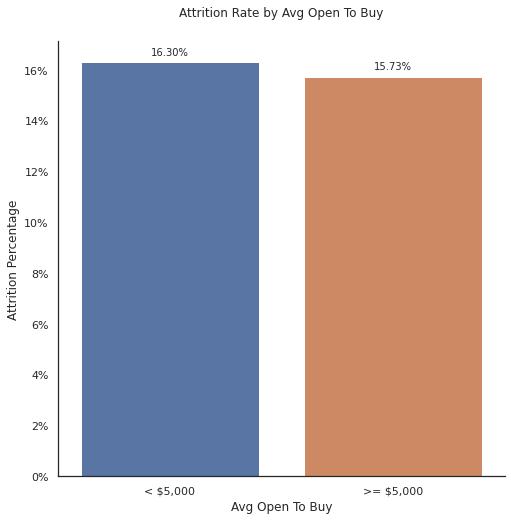


'Avg Open To Buy' testing results:

Z-Test:
The p-value for 'avg open to buy' is 0.447, therefore we can ACCEPT the null hypothesis.

Mean:
The average 'avg open to buy' for Existing Customers is 7470.27.
The average 'avg open to buy' for Attrited Customers is 7463.22.

T-Test:
The p-value for 'avg open to buy' is 0.977, therefore we can ACCEPT the null hypothesis.



In [21]:
######################################
############### DEFINE ###############
######################################
## define column name for preview and testing
column_name = 'avg_open_to_buy'


#######################################
############### PREVIEW ###############
#######################################
## DEFINE 
### number of preview bins
num_bins = max_bins()

## FORMAT
### PREVIEW PLOT size, label angle, label alignment (generally 3+ groups)
plot_width_prev, plot_height_prev = 12, 8
x_axis_ang_prev = 45
horiz_align_prev = 'right'


#######################################
############### TESTING ###############
#######################################
## TEST GROUPS
### DEFINE value being used to divide groups
less_than_num = 5000
### data to exclude from ordinal groups -- default to no_exclusions()
exclude_plus = no_exclusions()

## DEFINE formatted labels for the 2 test groups -- if numeric; group_label_1 is 'less than' -- group_label_2 is 'greater than or equal to'
group_label_1 = '< $5,000'
group_label_2 = '>= $5,000'

## TEST PLOT size, label angle, label alignment (2 groups)
plot_width_test, plot_height_test = 8, 8
x_axis_ang_test = 0
horiz_align_test = 'center'


########################################
############### PRINTING ###############
########################################
## PRINT
print_num_preview()
print_num_test()


#############################################
############### DEFINE CONCAT ###############
#############################################
## DEFINE concatenated DataFrame
df_attrition_all = concat_func()

### Total Amt Chng Q4 Q1
> change in transaction amount from quarter 1 to quarter 4


PREVIEW DATA

'Total Amt Chng Q4 Q1' is separated into 8 preliminary groups as a preview of the data.



attrition_flag,total_customers,attrited_customer,existing_customer,attrition_percent
total_amt_chng_q4_q1,,,,
"(-0.0034, 0.425]",326,184,142,56.44
"(0.425, 0.849]",7101,1019,6082,14.35
"(0.849, 1.274]",2433,421,2012,17.30
"(1.274, 1.698]",218,3,215,1.38
"(1.698, 2.123]",35,0,35,0.00
"(2.123, 2.548]",10,0,10,0.00
"(2.548, 2.972]",2,0,2,0.00
"(2.972, 3.397]",2,0,2,0.00


<Figure size 864x576 with 0 Axes>

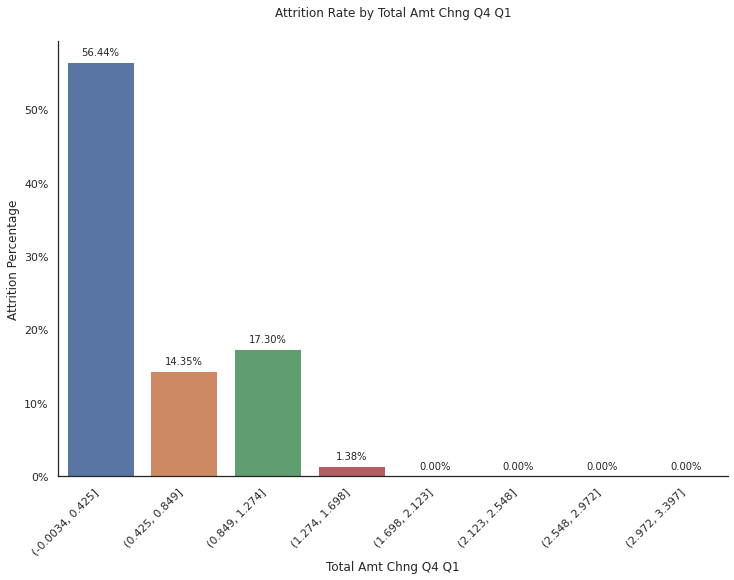




TESTING

'Total Amt Chng Q4 Q1' is grouped for testing by 'Negative Change' and 'Positive Change'.



attrition_flag,total_customers,attrited_customers,existing_customers,attrition_percent
total_amt_chng_q4_q1,,,,
Negative Change,9121,1484,7637,16.27
Positive Change,1006,143,863,14.21


<Figure size 576x576 with 0 Axes>

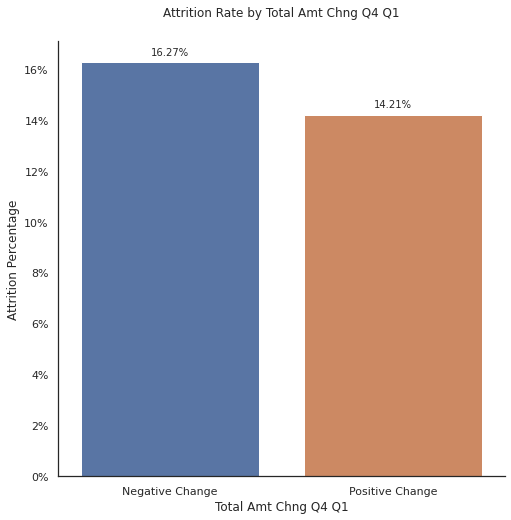


'Total Amt Chng Q4 Q1' testing results:

Z-Test:
The p-value for 'total amt chng q4 q1' is 0.091, therefore we can ACCEPT the null hypothesis.

Mean:
The average 'total amt chng q4 q1' for Existing Customers is 0.77.
The average 'total amt chng q4 q1' for Attrited Customers is 0.69.

T-Test:
The p-value for 'total amt chng q4 q1' is 4.837e-40, therefore we can REJECT the null hypothesis.



In [22]:
######################################
############### DEFINE ###############
######################################
## define column name for preview and testing
column_name = 'total_amt_chng_q4_q1'


#######################################
############### PREVIEW ###############
#######################################
## DEFINE 
### number of preview bins
num_bins = max_bins()

## FORMAT
### PREVIEW PLOT size, label angle, label alignment (generally 3+ groups)
plot_width_prev, plot_height_prev = 12, 8
x_axis_ang_prev = 45
horiz_align_prev = 'right'


#######################################
############### TESTING ###############
#######################################
## TEST GROUPS
### DEFINE value being used to divide groups
less_than_num = 1
### data to exclude from ordinal groups -- default to no_exclusions()
exclude_plus = no_exclusions()

## DEFINE formatted labels for the 2 test groups -- if numeric; group_label_1 is 'less than' -- group_label_2 is 'greater than or equal to'
group_label_1 = 'Negative Change'
group_label_2 = 'Positive Change'

## TEST PLOT size, label angle, label alignment (2 groups)
plot_width_test, plot_height_test = 8, 8
x_axis_ang_test = 0
horiz_align_test = 'center'


########################################
############### PRINTING ###############
########################################
## PRINT
print_num_preview()
print_num_test()


#############################################
############### DEFINE CONCAT ###############
#############################################
## DEFINE concatenated DataFrame
df_attrition_all = concat_func()

### Total Trans Amt
> total transaction amount over past 12 months


PREVIEW DATA

'Total Trans Amt' is separated into 8 preliminary groups as a preview of the data.



attrition_flag,total_customers,attrited_customer,existing_customer,attrition_percent
total_trans_amt,,,,
"(492.026, 2756.75]",3672,1215,2457,33.09
"(2756.75, 5003.5]",4574,156,4418,3.41
"(5003.5, 7250.25]",494,54,440,10.93
"(7250.25, 9497.0]",618,181,437,29.29
"(9497.0, 11743.75]",23,21,2,91.30
"(11743.75, 13990.5]",193,0,193,0.00
"(13990.5, 16237.25]",490,0,490,0.00
"(16237.25, 18484.0]",63,0,63,0.00


<Figure size 864x576 with 0 Axes>

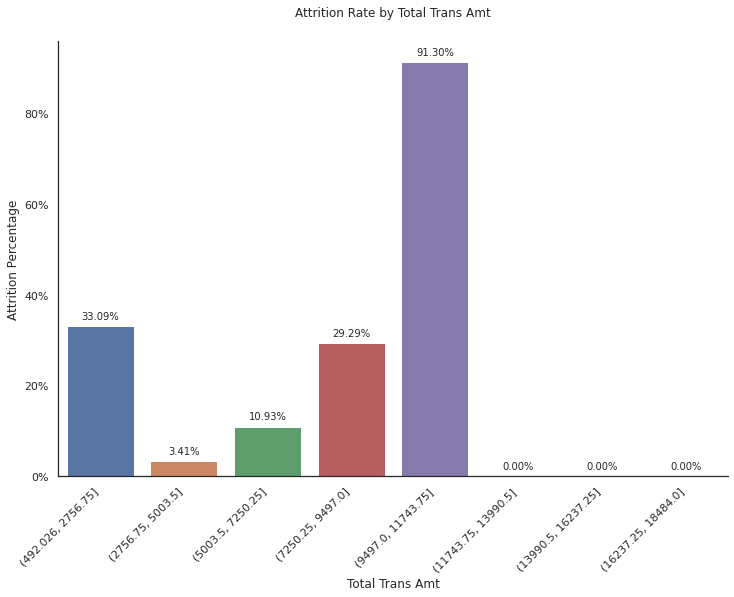




TESTING

'Total Trans Amt' is grouped for testing by '< $4,000' and '>= $4,000'.



attrition_flag,total_customers,attrited_customers,existing_customers,attrition_percent
total_trans_amt,,,,
"< $4,000",5287,1318,3969,24.93
">= $4,000",4840,309,4531,6.38


<Figure size 576x576 with 0 Axes>

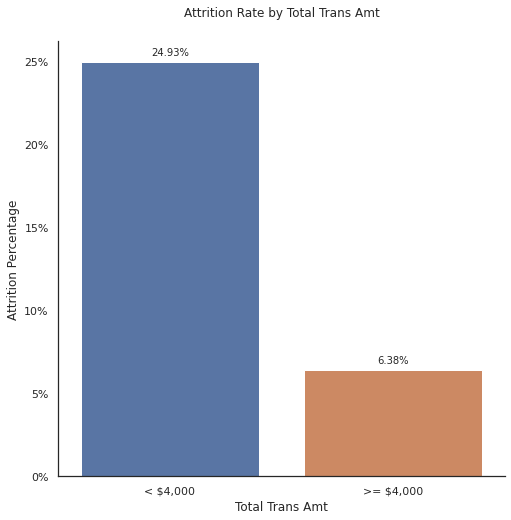


'Total Trans Amt' testing results:

Z-Test:
The p-value for 'total trans amt' is 1.167e-151, therefore we can REJECT the null hypothesis.

Mean:
The average 'total trans amt' for Existing Customers is 4654.66.
The average 'total trans amt' for Attrited Customers is 3095.03.

T-Test:
The p-value for 'total trans amt' is 1.857e-65, therefore we can REJECT the null hypothesis.



In [23]:
######################################
############### DEFINE ###############
######################################
## define column name for preview and testing
column_name = 'total_trans_amt'


#######################################
############### PREVIEW ###############
#######################################
## DEFINE 
### number of preview bins
num_bins = max_bins()

## FORMAT
### PREVIEW PLOT size, label angle, label alignment (generally 3+ groups)
plot_width_prev, plot_height_prev = 12, 8
x_axis_ang_prev = 45
horiz_align_prev = 'right'


#######################################
############### TESTING ###############
#######################################
## TEST GROUPS
### DEFINE value being used to divide groups
less_than_num = 4000
### data to exclude from ordinal groups -- default to no_exclusions()
exclude_plus = no_exclusions()

## DEFINE formatted labels for the 2 test groups -- if numeric; group_label_1 is 'less than' -- group_label_2 is 'greater than or equal to'
group_label_1 = '< $4,000'
group_label_2 = '>= $4,000'

## TEST PLOT size, label angle, label alignment (2 groups)
plot_width_test, plot_height_test = 8, 8
x_axis_ang_test = 0
horiz_align_test = 'center'


########################################
############### PRINTING ###############
########################################
## PRINT
print_num_preview()
print_num_test()


#############################################
############### DEFINE CONCAT ###############
#############################################
## DEFINE concatenated DataFrame
df_attrition_all = concat_func()

### Total Trans Ct
> total transaction count over past 12 months


PREVIEW DATA

'Total Trans Ct' is separated into 8 preliminary groups as a preview of the data.



attrition_flag,total_customers,attrited_customer,existing_customer,attrition_percent
total_trans_ct,,,,
"(9.871, 26.125]",384,145,239,37.76
"(26.125, 42.25]",1824,608,1216,33.33
"(42.25, 58.375]",1631,610,1021,37.40
"(58.375, 74.5]",2593,192,2401,7.40
"(74.5, 90.625]",2579,70,2509,2.71
"(90.625, 106.75]",647,2,645,0.31
"(106.75, 122.875]",361,0,361,0.00
"(122.875, 139.0]",108,0,108,0.00


<Figure size 864x576 with 0 Axes>

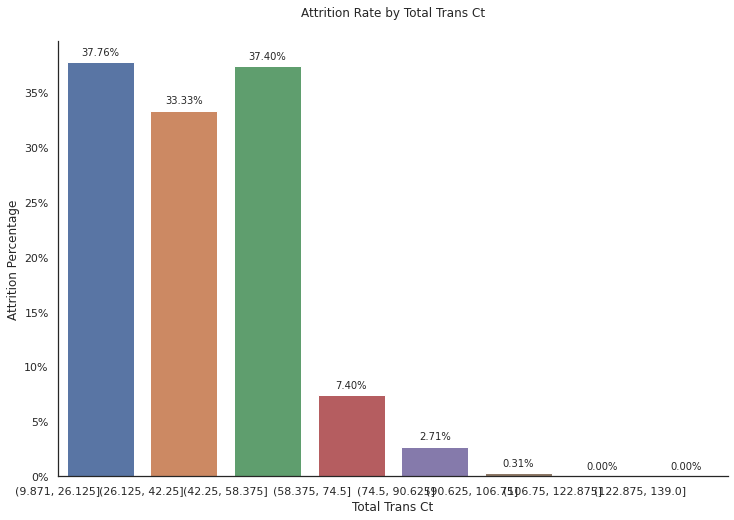




TESTING

'Total Trans Ct' is grouped for testing by '< 65' and '>= 65'.



attrition_flag,total_customers,attrited_customers,existing_customers,attrition_percent
total_trans_ct,,,,
< 65,4607,1452,3155,31.52
>= 65,5520,175,5345,3.17


<Figure size 576x576 with 0 Axes>

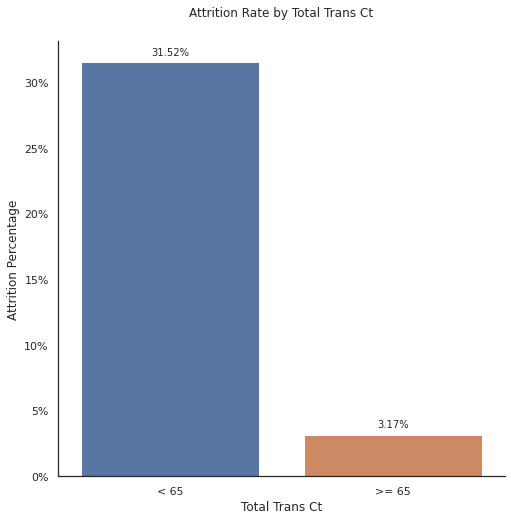


'Total Trans Ct' testing results:

Z-Test:
The p-value for 'total trans ct' is 0.000e+00, therefore we can REJECT the null hypothesis.

Mean:
The average 'total trans ct' for Existing Customers is 68.67.
The average 'total trans ct' for Attrited Customers is 44.93.

T-Test:
The p-value for 'total trans ct' is 0.000e+00, therefore we can REJECT the null hypothesis.



In [24]:
######################################
############### DEFINE ###############
######################################
## define column name for preview and testing
column_name = 'total_trans_ct'


#######################################
############### PREVIEW ###############
#######################################
## DEFINE 
### number of preview bins
num_bins = max_bins()

## FORMAT
### PREVIEW PLOT size, label angle, label alignment (generally 3+ groups)
plot_width_prev, plot_height_prev = 12, 8
x_axis_ang_prev = 0
horiz_align_prev = 'right'


#######################################
############### TESTING ###############
#######################################
## TEST GROUPS
### DEFINE value being used to divide groups
less_than_num = 65
### data to exclude from ordinal groups -- default to no_exclusions()
exclude_plus = no_exclusions()

## DEFINE formatted labels for the 2 test groups -- if numeric; group_label_1 is 'less than' -- group_label_2 is 'greater than or equal to'
group_label_1 = '< 65'
group_label_2 = '>= 65'

## TEST PLOT size, label angle, label alignment (2 groups)
plot_width_test, plot_height_test = 8, 8
x_axis_ang_test = 0
horiz_align_test = 'center'


########################################
############### PRINTING ###############
########################################
## PRINT
print_num_preview()
print_num_test()


#############################################
############### DEFINE CONCAT ###############
#############################################
## DEFINE concatenated DataFrame
df_attrition_all = concat_func()

### Total Ct Chng Q4 Q1
> change in transaction count from quarter 1 to quarter 4


PREVIEW DATA

'Total Ct Chng Q4 Q1' is separated into 8 preliminary groups as a preview of the data.



attrition_flag,total_customers,attrited_customer,existing_customer,attrition_percent
total_ct_chng_q4_q1,,,,
"(-0.00371, 0.464]",1124,608,516,54.09
"(0.464, 0.928]",7798,933,6865,11.96
"(0.928, 1.393]",1081,81,1000,7.49
"(1.393, 1.857]",83,3,80,3.61
"(1.857, 2.321]",24,1,23,4.17
"(2.321, 2.786]",10,1,9,10.00
"(2.786, 3.25]",3,0,3,0.00
"(3.25, 3.714]",4,0,4,0.00


<Figure size 864x576 with 0 Axes>

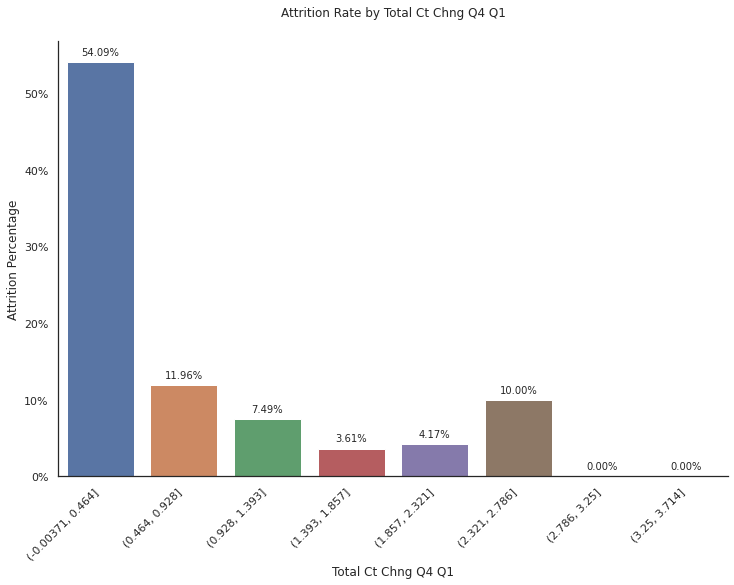




TESTING

'Total Ct Chng Q4 Q1' is grouped for testing by 'Negative Change' and 'Positive Change'.



attrition_flag,total_customers,attrited_customers,existing_customers,attrition_percent
total_ct_chng_q4_q1,,,,
Negative Change,9293,1568,7725,16.87
Positive Change,834,59,775,7.07


<Figure size 576x576 with 0 Axes>

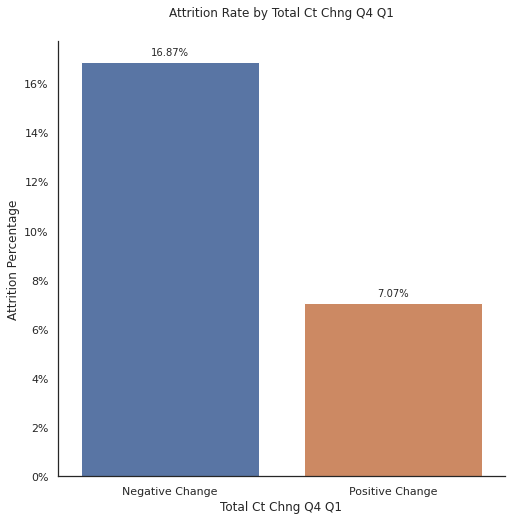


'Total Ct Chng Q4 Q1' testing results:

Z-Test:
The p-value for 'total ct chng q4 q1' is 1.352e-13, therefore we can REJECT the null hypothesis.

Mean:
The average 'total ct chng q4 q1' for Existing Customers is 0.74.
The average 'total ct chng q4 q1' for Attrited Customers is 0.55.

T-Test:
The p-value for 'total ct chng q4 q1' is 1.648e-195, therefore we can REJECT the null hypothesis.



In [25]:
######################################
############### DEFINE ###############
######################################
## define column name for preview and testing
column_name = 'total_ct_chng_q4_q1'


#######################################
############### PREVIEW ###############
#######################################
## DEFINE 
### number of preview bins
num_bins = max_bins()

## FORMAT
### PREVIEW PLOT size, label angle, label alignment (generally 3+ groups)
plot_width_prev, plot_height_prev = 12, 8
x_axis_ang_prev = 45
horiz_align_prev = 'right'


#######################################
############### TESTING ###############
#######################################
## TEST GROUPS
### DEFINE value being used to divide groups
less_than_num = 1
### data to exclude from ordinal groups -- default to no_exclusions()
exclude_plus = no_exclusions()

## DEFINE formatted labels for the 2 test groups -- if numeric; group_label_1 is 'less than' -- group_label_2 is 'greater than or equal to'
group_label_1 = 'Negative Change'
group_label_2 = 'Positive Change'

## TEST PLOT size, label angle, label alignment (2 groups)
plot_width_test, plot_height_test = 8, 8
x_axis_ang_test = 0
horiz_align_test = 'center'


########################################
############### PRINTING ###############
########################################
## PRINT
print_num_preview()
print_num_test()


#############################################
############### DEFINE CONCAT ###############
#############################################
## DEFINE concatenated DataFrame
df_attrition_all = concat_func()

### Avg Utilization Ratio
> average creidit utilization ratio over past 12 months


PREVIEW DATA

'Avg Utilization Ratio' is separated into 8 preliminary groups as a preview of the data.



attrition_flag,total_customers,attrited_customer,existing_customer,attrition_percent
avg_utilization_ratio,,,,
"(-0.000999, 0.125]",4394,1096,3298,24.94
"(0.125, 0.25]",1428,136,1292,9.52
"(0.25, 0.375]",943,105,838,11.13
"(0.375, 0.5]",811,62,749,7.64
"(0.5, 0.624]",945,59,886,6.24
"(0.624, 0.749]",854,51,803,5.97
"(0.749, 0.874]",572,79,493,13.81
"(0.874, 0.999]",180,39,141,21.67


<Figure size 864x576 with 0 Axes>

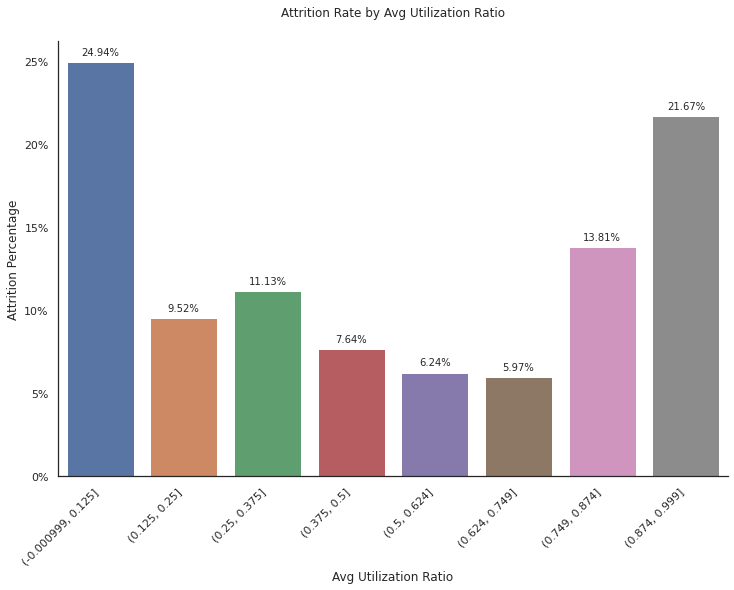




TESTING

'Avg Utilization Ratio' is grouped for testing by '< 25%' and '>= 25%'.



attrition_flag,total_customers,attrited_customers,existing_customers,attrition_percent
avg_utilization_ratio,,,,
< 25%,5822,1232,4590,21.16
>= 25%,4305,395,3910,9.18


<Figure size 576x576 with 0 Axes>

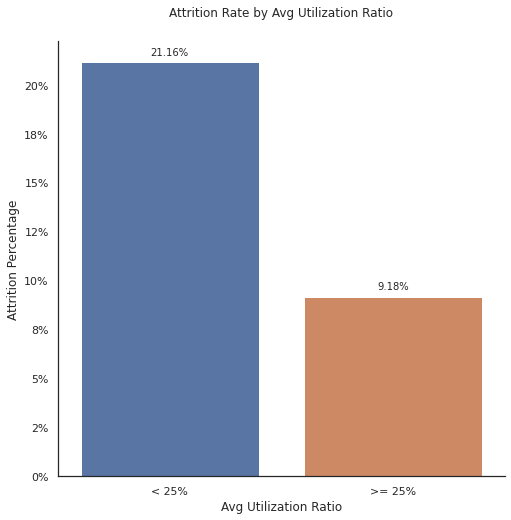


'Avg Utilization Ratio' testing results:

Z-Test:
The p-value for 'avg utilization ratio' is 8.158e-61, therefore we can REJECT the null hypothesis.

Mean:
The average 'avg utilization ratio' for Existing Customers is 0.30.
The average 'avg utilization ratio' for Attrited Customers is 0.16.

T-Test:
The p-value for 'avg utilization ratio' is 3.358e-73, therefore we can REJECT the null hypothesis.



In [26]:
######################################
############### DEFINE ###############
######################################
## define column name for preview and testing
column_name = 'avg_utilization_ratio'


#######################################
############### PREVIEW ###############
#######################################
## DEFINE 
### number of preview bins
num_bins = max_bins()

## FORMAT
### PREVIEW PLOT size, label angle, label alignment (generally 3+ groups)
plot_width_prev, plot_height_prev = 12, 8
x_axis_ang_prev = 45
horiz_align_prev = 'right'


#######################################
############### TESTING ###############
#######################################
## TEST GROUPS
### DEFINE value being used to divide groups
less_than_num = .25
### data to exclude from ordinal groups -- default to no_exclusions()
exclude_plus = no_exclusions()

## DEFINE formatted labels for the 2 test groups -- if numeric; group_label_1 is 'less than' -- group_label_2 is 'greater than or equal to'
group_label_1 = '< 25%'
group_label_2 = '>= 25%'

## TEST PLOT size, label angle, label alignment (2 groups)
plot_width_test, plot_height_test = 8, 8
x_axis_ang_test = 0
horiz_align_test = 'center'


########################################
############### PRINTING ###############
########################################
## PRINT
print_num_preview()
print_num_test()


#############################################
############### DEFINE CONCAT ###############
#############################################
## DEFINE concatenated DataFrame
df_attrition_all = concat_func()

## Comparison of Attrition Percentage by category

### All Categories

The attrition percentage by category is as follows:

                 category  min_attrition_percent  max_attrition_percent  attrition_percent_range
           Total Trans Ct                   3.17                  31.52                    28.35
          Total Trans Amt                   6.38                  24.93                    18.55
      Total Revolving Bal                   7.99                  24.61                    16.62
    Contacts Count 12 Mon                  10.11                  22.17                    12.06
    Avg Utilization Ratio                   9.18                  21.16                    11.98
   Months Inactive 12 Mon                  11.18                  21.97                    10.79
 Total Relationship Count                  11.43                  21.96                    10.53
      Total Ct Chng Q4 Q1                   7.07                  16.87                     9.80
                   Gender                  14.62                  17.36   

<Figure size 1152x576 with 0 Axes>

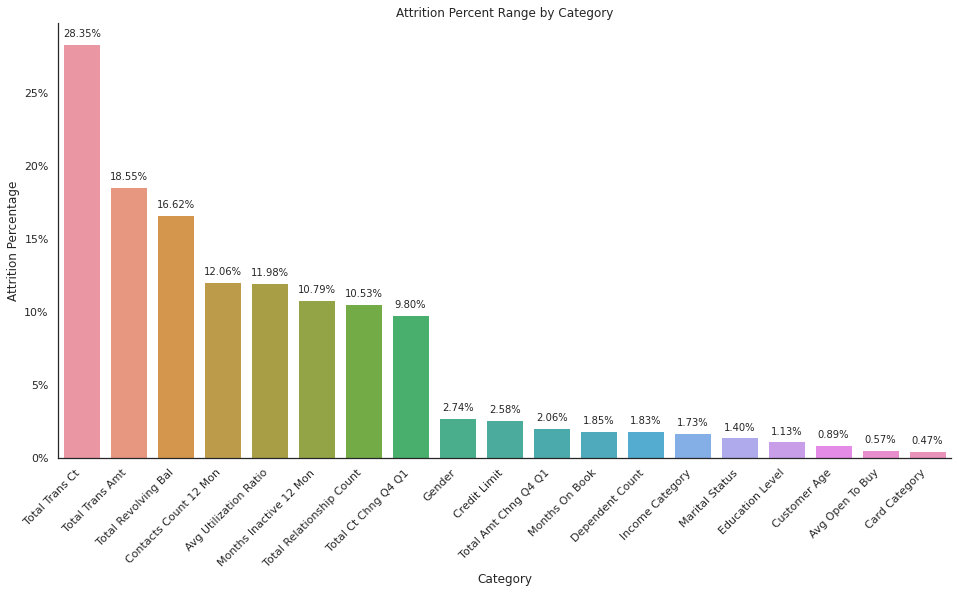

In [27]:
############################
########## FORMAT ##########
############################

## REPLACE '_' with a space for the 'Category' column
df_attrition = df_attrition_all
df_attrition_all['category'] = df_attrition_all['category'].str.replace('_',' ').str.title()
df_attrition_all = df_attrition_all.sort_values(by=['attrition_percent_range'], ascending=False).to_string(index=False)

## PRINT
print('The attrition percentage by category is as follows:\n')
print(df_attrition_all)


##################################################
# BAR PLOT -- all columns
## SETTINGS
plotsize = plt.figure(figsize=(16, 8))
ay, fig = plt.subplots(figsize=(16, 8))   
sns.set_style("white")
## CREATE bar plot
bplot = sns.barplot(x='category', 
                    y='attrition_percent_range', 
                    data=df_attrition.sort_values(by=['attrition_percent_range'], 
                                                  ascending=False))
plt.xlabel('Category')
plt.ylabel('Attrition Percentage')
plt.title('Attrition Percent Range by Category')
sns.despine()
## FORMAT bar plot
for p in bplot.patches:
  bplot.annotate('{:.2f}%'.format(p.get_height()), 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 va = 'center', 
                 xytext = (0, 10), 
                 textcoords = 'offset points',
                 ha = 'center')
y = 'Attrition Percentage'
ylabels = ['{:.0f}'.format(y) + '%' for y in bplot.get_yticks()]
bplot.set_yticklabels(ylabels)
bplot.set_xticklabels(bplot.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
## PRINT bar plot
print('\n')
plt.show()

### Filtered Categories
For further analysis filter categories by 'Attrition Percent Range' and plot the results


There is a clear drop-off in 'Attrition Percent Range' after 'Total Ct Chng Q4 Q1' at '9.8%'

                 category  min_attrition_percent  max_attrition_percent  attrition_percent_range
           Total Trans Ct                   3.17                  31.52                    28.35
          Total Trans Amt                   6.38                  24.93                    18.55
      Total Revolving Bal                   7.99                  24.61                    16.62
    Contacts Count 12 Mon                  10.11                  22.17                    12.06
    Avg Utilization Ratio                   9.18                  21.16                    11.98
   Months Inactive 12 Mon                  11.18                  21.97                    10.79
 Total Relationship Count                  11.43                  21.96                    10.53
      Total Ct Chng Q4 Q1                   7.07                  16.87                     9.80




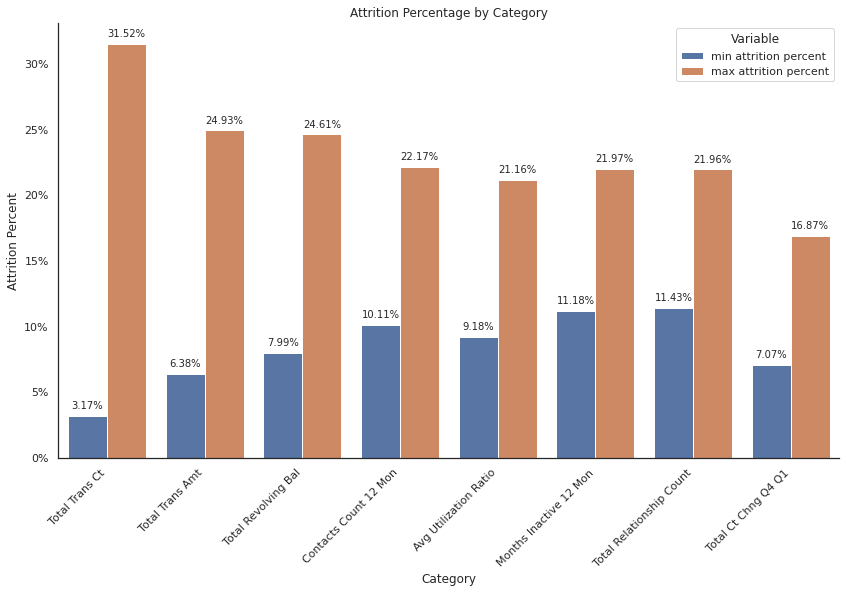

In [28]:
############################
########## FILTER ##########
############################

## FILTER by attrition percent range
df_attrition_filtered = df_attrition.loc[df_attrition['attrition_percent_range'] >= 9.8].sort_values(by=['attrition_percent_range'], 
                                                                                                     ascending=False)
## PRINT
print('\nThere is a clear drop-off in \'Attrition Percent Range\' after \'Total Ct Chng Q4 Q1\' at \'9.8%\'\n')
print(df_attrition_filtered.to_string(index=False))


##############################
########## BAR PLOT ##########
##############################

## REMOVE -- remove range column
df_attrition_drop = df_attrition_filtered.drop(['attrition_percent_range'], axis=1)


## FORMAT column names
df_attrition_drop.columns = df_attrition_drop.columns.str.replace("_", " ")


## BAR PLOT
fig, ax1 = plt.subplots(figsize=(14, 8))
tidy = df_attrition_drop.melt(id_vars='category').rename(columns=str.title)
bplot = sns.barplot(x='Category', y='Value', hue='Variable', data=tidy, ax=ax1)
plt.xlabel('Category')
plt.ylabel('Attrition Percent')
plt.title('Attrition Percentage by Category')
sns.despine()

## FORMAT
### bar plot
for p in bplot.patches:
  bplot.annotate('{:.2f}%'.format(p.get_height()), 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 va = 'center', 
                 xytext = (0, 10), 
                 textcoords = 'offset points',
                 ha = 'center')

y = 'Attrition Percentage'
ylabels = ['{:.0f}'.format(y) + '%' for y in bplot.get_yticks()]
bplot.set_yticklabels(ylabels)
bplot.set_xticklabels(bplot.get_xticklabels(), 
                      rotation = 45, 
                      horizontalalignment = 'right')


## PRINT
### bar plot
print('\n')
plt.show()

# Recap
The remaining categories are those with the largest 'Attrition Percent Range', therefore implying a stronger influence on attrition. 
## Conclusion
Total Transaction Count, Total Transaction Amount, and Total Revolving Balance are the most influential factors affecting credit card attrition rates. 
## Recommendations
- It is recommended that when the customer 'Total Transaction Count' over 12 months is less than 60 we should target customers with promotions.
- It is recommended that when the customer 'Total Transaction Amount' over 12 months is less than \$4,000 we should target customers with promotions. 
- It is recommended that when the customer 'Total Revolving Balance' is less than \$1,250 we should target customers with promotions.


                    category  attrition_percent_range
0            Total Trans Ct                    28.35
0           Total Trans Amt                    18.55
0       Total Revolving Bal                    16.62
0     Contacts Count 12 Mon                    12.06
0     Avg Utilization Ratio                    11.98
0    Months Inactive 12 Mon                    10.79
0  Total Relationship Count                    10.53
0       Total Ct Chng Q4 Q1                     9.80



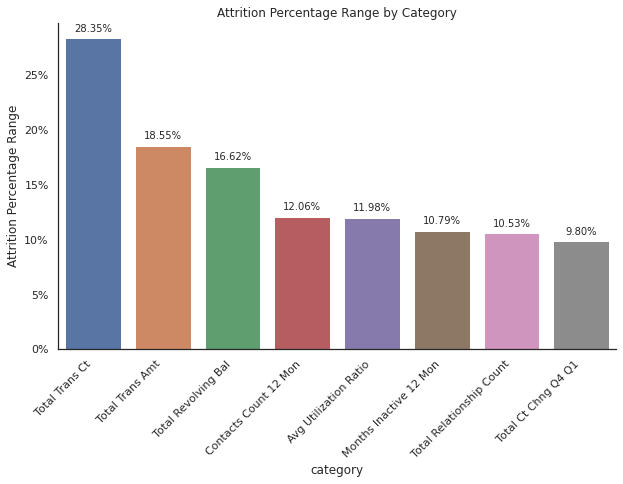



Conclusion:
Total Transaction Count, Total Transaction Amount,
and Total Revolving Balance are the most influential
factors affecting credit card attrition rates.


Recommendations:
- It is recommended that when the customer 'Total Transaction Count' over 
  12 months is less than 60 we should target customers with promotions.

- It is recommended that when the customer 'Total Transaction Amount' over 
  12 months is less than $4,000 we should target customers with promotions.

- It is recommended that when the customer 'Total Revolving Balance' is less 
  than $1,250 we should target customers with promotions.


In [29]:
## PRINT
print('\n', df_attrition_filtered.drop(['min_attrition_percent','max_attrition_percent'], axis=1))


##################################################
## BOX PLOT
plt.subplots(figsize=(10, 6))

bplot = sns.barplot(x='category', y='attrition_percent_range', data=df_attrition_filtered)
plt.title('Attrition Percentage Range by Category')
plt.ylabel('Attrition Percentage Range')
bplot.set_xticklabels(bplot.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
sns.despine()

for p in bplot.patches:
  bplot.annotate('{:.2f}%'.format(p.get_height()), 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 va = 'center', 
                 xytext = (0, 10), 
                 textcoords = 'offset points',
                 ha = 'center')

y = 'Attrition_Percent_Range'
ylabels = ['{:.0f}'.format(y) + '%' for y in bplot.get_yticks()]
bplot.set_yticklabels(ylabels)


## PRINT
print('')
plt.show()
print('\n')
print('Conclusion:')
print('Total Transaction Count, Total Transaction Amount,\
\nand Total Revolving Balance are the most influential\
\nfactors affecting credit card attrition rates.')
print('\n')
print('Recommendations:')
print('- It is recommended that when the customer \'Total Transaction Count\' over \n  12 months is less than 60 we should target customers with promotions.')
print('')
print('- It is recommended that when the customer \'Total Transaction Amount\' over \n  12 months is less than $4,000 we should target customers with promotions.')
print('')
print('- It is recommended that when the customer \'Total Revolving Balance\' is less \n  than $1,250 we should target customers with promotions.')